<meta name="viewport" content="width=device-width, initial-scale=1">
<meta name="description" content="A deep learning project for traffic sign classification using convolutional neural networks and TensorFlow on the GTSRB dataset.">
<title>Red Light, Green Light | Model Analysis</title>
<link href="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/css/bootstrap.min.css" rel="stylesheet">
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.5.2/css/all.min.css">
<link rel="stylesheet" href="../static/css/styles.css">
<link rel="icon" href="./static/images/favicon.ico" type="image/ico" />

<!-- Navigation-->
<nav class="navbar navbar-expand-lg navbar-light fixed-top" id="mainNav">
  <div class="container px-4 px-lg-5">
    <a class="navbar-brand" href="executive_summary.html">Home</a>
    <button
      class="navbar-toggler"
      type="button"
      data-bs-toggle="collapse"
      data-bs-target="#navbarResponsive"
      aria-controls="navbarResponsive"
      aria-expanded="false"
      aria-label="Toggle navigation"
    >
      Menu
      <i class="fas fa-bars"></i>
    </button>
    <div class="collapse navbar-collapse" id="navbarResponsive">
      <ul class="navbar-nav ms-auto py-4 py-lg-0">
        <li class="nav-item">
          <a
            class="nav-link px-lg-3 py-3 py-lg-4"
            href="executive_summary.html"
            >Executive Summary</a
          >
        </li>
        <!-- <li class="nav-item">
          <a
            class="nav-link px-lg-3 py-3 py-lg-4"
            href="model_analysis.html"
            >Model Analysis</a
          >
        </li> -->
        <li class="nav-item">
          <a class="nav-link px-lg-3 py-3 py-lg-4" href="visual_key.html"
            >Reference: Visual Key</a
          >
        </li>
      </ul>
    </div>
  </div>
</nav>


<!-- Command line to convert notebook to HTML without code cells: -->
<!-- jupyter nbconvert model_analysis.ipynb --to html --no-input --output ../templates/model_analysis.html -->

In [1]:
# Command line to convert notebook to HTML without code cells:
# jupyter nbconvert model_analysis.ipynb --to html --no-input --output ../templates/model_analysis.html

from IPython.display import display, HTML

# Display banner image
display(HTML('''
<div style="max-width:900px;margin:auto;">
  <img src="../static/images/GTSRB_banner.png" class="img-soft-border" alt="Traffic Signs Banner" style="width:100%;">
</div>
'''))

<link rel="stylesheet" href="../static/css/styles.css">

<div class="project-banner">
  <span class="project-banner-main">
    <span class="red-light">Red Light,</span>  <span class="green-light">Green Light</span>
  </span>
  <span class="project-banner-sub">Teaching AI to Read Traffic Signs</span>
</div>

<h3>A deep learning project for traffic sign classification using convolutional neural networks (CNNs) and TensorFlow on the GTSRB dataset.</h3>

<div id="title">
  Model Analysis
  <span class="subtitle">Comparative Evaluation and Test Set Results</span>
</div>

## Table of Contents
- [Introduction](#introduction)
- [Dataset Overview](#dataset-overview)
- [Model Architecture](#model-architecture)
- [Training and Evaluation Outputs](#training-and-evaluation)
  - [Baseline Model](#baseline-model)
  - [Baseline Model with Class Weights](#baseline-model-with-class-weights)
  - [Two Convolutional Layers](#two-convolutional-layers)
  - [Baseline Model with Batch Normalization](#baseline-model-with-batch-normalization)
  - [Two Convolutional Layers with Batch Normalization](#two-convolutional-layers-with-batch-normalization)
  - [Two Convolutional + Dense Layers](#two-convolutional--dense-layers)
  - [Two Convolutional + Dense Layers with Batch Normalization](#two-convolutional--dense-layers-with-batch-normalization)
- [Comparative Model Analysis](#comparative-model-analysis)
- [Test Set Evaluation](#test-set-evaluation)
- [Interpretation of Test Results](#interpretation-of-test-results)

<a id="introduction"></a>

# Introduction

[Back to Top](#)

<span style="font-weight: bold;">Data Source:</span> <a href="https://benchmark.ini.rub.de/gtsrb_news.html" target="_blank">German Traffic Sign Recognition Benchmark (GTSRB) dataset</a>

The German Traffic Sign Recognition Benchmark (GTSRB) is a widely used dataset for traffic sign classification, containing over 50,000 labeled images across 43 classes. Images capture signs under varied real-world conditions such as lighting, perspective, and occlusion. Accurate recognition of these signs is critical for autonomous driving, driver-assistance systems, and road safety research.  

In this project, we design a series of CNN models to classify traffic signs in GTSRB. Architectural adjustments—class weighting, added convolutional layers, and batch normalization—are introduced incrementally, allowing us to trace improvements from a simple baseline to a high-performing model.  

In [2]:
from IPython.display import display, HTML

# Display banner image
display(HTML('''
<div style="max-width:900px;margin:auto;">
  <img src="../static/images/GTSRB_banner.png" class="img-soft-border" alt="Traffic Signs Banner" style="width:100%;">
</div>
'''))

In [3]:
# Import dependencies
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
from collections import Counter
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import tensorflow as tf
from sklearn.model_selection import train_test_split
# from IPython.display import display, HTML

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Ensure reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# Global constants
# EPOCHS = 10
IMG_WIDTH = 30
IMG_HEIGHT = 30
NUM_CATEGORIES = 43
# TEST_SIZE = 0.4

# Load sign names as a dictionary: {class_id: sign_name}
signnames_df = pd.read_csv("../resources/signnames.csv")
SIGNNAME_MAP = dict(zip(signnames_df["ClassId"], signnames_df["SignName"]))

In [5]:
# Function to load data from directory
def load_data(data_dir):
    """
    Load image data from directory `data_dir`.

    Assume `data_dir` has one directory named after each category, numbered
    0 through NUM_CATEGORIES - 1. Inside each category directory will be some
    number of image files.

    Return tuple `(images, labels)`. `images` should be a list of all
    of the images in the data directory, where each image is formatted as a
    numpy ndarray with dimensions IMG_WIDTH x IMG_HEIGHT x 3. `labels` should
    be a list of integer labels, representing the categories for each of the
    corresponding `images`.
    """
    # Initialize lists to hold images and labels
    images = []
    labels = []

    # Process each image and append image and label to lists
    # Walk through the directory tree
    for dirpath, dirnames, filenames in os.walk(data_dir):
        for filename in filenames:
            # Construct full file path
            image_path = os.path.join(dirpath, filename)
            # Read and resize the image
            image = cv2.imread(image_path)
            image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
            # Normalize pixel values to the range [0, 1] by dividing by 255.0
            # And converts from an integer type to a float type
            image = image / 255.0
            # Append image and label to lists
            images.append(image)
            # Extract label from directory name
            labels.append(int(os.path.basename(dirpath)))

    # Return the tuple of images and labels
    return (images, labels)

In [6]:
# Evaluation functions

# These functions will generate and save the following:
# Training/validation loss and accuracy curves
# Confusion matrix plot
# Classification report
# Show misclassified images
# Most common misclassifications
# Misclassification confidence histogram
# Model summary


# Training Curve
def plot_and_save_training_curves(history, model_name="model"):
    """
    Plot and save training curves for loss and accuracy.
    history: Keras History object from model training
    model_name: string, name to use in saved filenames
    """
    plt.figure(figsize=(12, 5))
    plt.suptitle(
        f"Training and Validation Curves\n({model_name.replace('_', ' ')})", fontsize=16
    )

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Tight layout and save
    plt.tight_layout()
    plt.savefig(f"../results/images/{model_name}_training_curves.png")
    plt.show()

    # Spacer
    display(HTML('<div class="spacer"></div>'))


# Confusion Matrix
def plot_and_save_confusion_matrix(y_true, y_pred_classes, model_name="model"):
    """
    Plot and save confusion matrix.
    y_true: true labels (1D array, int)
    y_pred_classes: predicted class indices (1D array, int)
    model_name: string, name to use in saved filenames
    """
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation="vertical")
    plt.title(f"Confusion Matrix\n({model_name.replace('_', ' ')})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Save the figure
    plt.savefig(f"../results/images/{model_name}_confusion_matrix.png")
    plt.show()


# Classification Report
def save_classification_report(y_true, y_pred_classes, model_name="model"):
    """
    Generate and save classification report as CSV.
    y_true: true labels (1D array, int)
    y_pred_classes: predicted class indices (1D array, int)
    model_name: string, name to use in saved filenames
    """
    # Classification Report, convert to DataFrame and save as CSV
    report = classification_report(y_true, y_pred_classes, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(f"../results/{model_name}_classification_report.csv")

    # Reorder rows: move 'accuracy', 'macro avg', 'weighted avg' to the top
    special_rows = ["accuracy", "macro avg", "weighted avg"]
    other_rows = [row for row in report_df.index if row not in special_rows]
    new_order = special_rows + other_rows
    report_df = report_df.loc[new_order]

    # Print the report to console
    display(HTML('<div class="classification">Classification Report</div>'))
    display(report_df)


# Show Misclassified Images
def show_top_misclassifications(
    x,
    y_true,
    y_pred,
    y_prob,
    signname_map=None,
    top_n=4,
    per_class=2,
    model_name="model",
):
    """
    Display and save top misclassified images.
    x: images (4D array, shape [n_samples, IMG_WIDTH, IMG_HEIGHT, 3])
    y_true: true labels (1D array, int)
    y_pred: predicted class indices (1D array, int)
    y_prob: softmax probabilities (2D array, shape [n_samples, n_classes])
    signname_map: dict mapping class_id to sign name (optional, defaults to SIGNNAME_MAP)
    top_n: number of top misclassification types to show
    per_class: number of images to show per misclassification type
    model_name: string, name to use in saved filenames
    """
    # Spacer
    display(HTML('<div class="spacer"></div>'))

    # Use default signname map if none provided
    if signname_map is None:
        signname_map = SIGNNAME_MAP

    # Find misclassifications, count occurrences, and get top N errors
    errors = [(t, p) for t, p in zip(y_true, y_pred) if t != p]
    counter = Counter(errors)
    top_errors = counter.most_common(top_n)
    images_to_show = []
    labels_to_show = []
    confidences = []

    # Collect images, labels, and confidences for top misclassifications
    for (true, pred), _ in top_errors:
        # Find indices of misclassifications
        idxs = np.where((y_true == true) & (y_pred == pred))[0]
        # Randomly shuffle and select up to `per_class` images
        if len(idxs) > per_class:
            idxs = np.random.choice(idxs, per_class, replace=False)
        # Append images, labels, and confidences
        for idx in idxs:
            images_to_show.append(x[idx])
            labels_to_show.append((true, pred))
            confidences.append(y_prob[idx, pred])

    # Plot the images
    cols = 4
    rows = int(np.ceil(len(images_to_show) / cols))
    plt.figure(figsize=(16, 8))
    plt.suptitle(
        f"Sample of Top {top_n} Most Common Misclassifications\n"
        f"({model_name.replace('_', ' ')})\n"
        "Each image shows: True label, Predicted label, and Model Confidence",
        fontsize=16,
    )
    for i in range(len(images_to_show)):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images_to_show[i])
        true_label, pred_label = labels_to_show[i]
        conf = confidences[i]
        true_name = signname_map.get(true_label, str(true_label))
        pred_name = signname_map.get(pred_label, str(pred_label))
        plt.title(f"T:{true_name}\nP:{pred_name}\nConfidence:{conf:.2f}")
        plt.axis("off")

    # Tight layout and save
    plt.tight_layout()
    plt.savefig(f"../results/images/{model_name}_top_misclassifications.png")
    plt.show()

    # Spacer
    display(HTML('<div class="spacer"></div>'))


# Most Common Misclassifications
def most_common_misclassifications(y_true, y_pred, top_n=5, signname_map=SIGNNAME_MAP):
    """
    Print the most common misclassifications.
    y_true: true labels (1D array, int)
    y_pred: predicted class indices (1D array, int)
    top_n: number of top misclassification types to show
    signname_map: dictionary mapping class ids to sign names
    """
    # Find misclassifications, count occurrences, and print top N errors
    errors = [(t, p) for t, p in zip(y_true, y_pred) if t != p]
    counter = Counter(errors)
    display(
        HTML(
            f'<div class="misclass-summary" style="font-size: 1.25em;">Total Misclassifications: {len(errors)}</div>'
        )
    )
    display(
        HTML(
            f'<div class="misclass-summary" style="text-decoration: underline;">Top {top_n} Most Common Misclassifications:</div>'
        )
    )
    for (true, pred), count in counter.most_common(top_n):
        true_name = signname_map.get(true, str(true))
        pred_name = signname_map.get(pred, str(pred))
        display(
            HTML(
                f'<div class="misclass-detail">* {true_name} (label {true}) predicted as {pred_name} (label {pred}) — {count} times</div>'
            )
        )


# Misclassification Confidence Histogram
def plot_misclassification_confidence_histogram(
    y_true, y_pred_classes, y_prob, bins=10, model_name="model"
):
    """
    Plot and save a histogram of model confidence (predicted probability) for misclassified samples.
    y_true: true labels (1D array, int)
    y_pred_classes: predicted class indices (1D array, int)
    y_prob: softmax probabilities (2D array, shape [n_samples, n_classes])
    bins: number of bins in the histogram
    model_name: string, name to use in saved filenames
    """
    # Spacer
    display(HTML('<div class="spacer"></div>'))
    
    # Find indices of misclassified samples
    misclassified = np.where(y_true != y_pred_classes)[0]
    # If no misclassifications, print message and return
    if len(misclassified) == 0:
        print("No misclassifications to plot.")
        return

    # Get predicted probabilities (confidences) for the predicted classes of misclassified samples
    confidences = y_prob[misclassified, y_pred_classes[misclassified]]

    # Plot histogram
    plt.figure(figsize=(8, 4))
    plt.hist(confidences, bins=bins, color="tomato", edgecolor="black")
    plt.title(
        f"Model Confidence in Misclassifications\n"
        f"({model_name.replace('_', ' ')})\n"
        f"{len(misclassified)} errors of {len(y_true)} samples"
    )
    plt.xlabel("Predicted Probability (Confidence)")
    plt.ylabel("Number of Misclassified Samples")
    plt.ylim(0, 85) # Set y-axis for consistency across models
    # Save the figure
    plt.tight_layout()
    plt.savefig(
        f"../results/images/{model_name}_misclassification_confidence_histogram.png"
    )
    plt.show()


# Model Summary
def save_model_summary(model, model_name="model"):
    """
    Save model summary to a text file.
    model: Keras model
    model_name: string, name to use in saved filename
    """
    with open(f"../results/{model_name}_summary.txt", "w") as f:
        model.summary(print_fn=lambda x: f.write(x + "\n"))
    # print("Model summary saved.")

<a id="dataset-overview"></a>

## Dataset Overview

[Back to Top](#)

The GTSRB dataset includes:  
- **Classes:** 43  
- **Images:** ~50,000  
- **Conditions:** Diverse perspectives, lighting, and partial occlusions  

Some classes are well represented (e.g., common speed limit signs), while others are rare. This imbalance creates challenges for models, which may otherwise bias toward frequent categories. The task requires high overall accuracy and reliable recognition of rare or visually similar signs.  


In [7]:
# Display Zero-Indexed GTSRB signs
display(HTML('''
<div style="max-width:900px;margin:auto;">
  <img src="../static/images/GTSRB_0-Indexed.png" class="img-soft-border" alt="Zero-Indexed GTSRB Signs" style="width:100%;">
</div>
'''))

<p class="caption" style="text-align: center;">
    <em
    >Pictograms of all 43 GTSRB classes, in order. Note that real-world signs may appear in different shapes or colors. See the <a href="../templates/visual_key.html">Visual Key</a> for a full reference to all sign classes.
    </em>
</p>


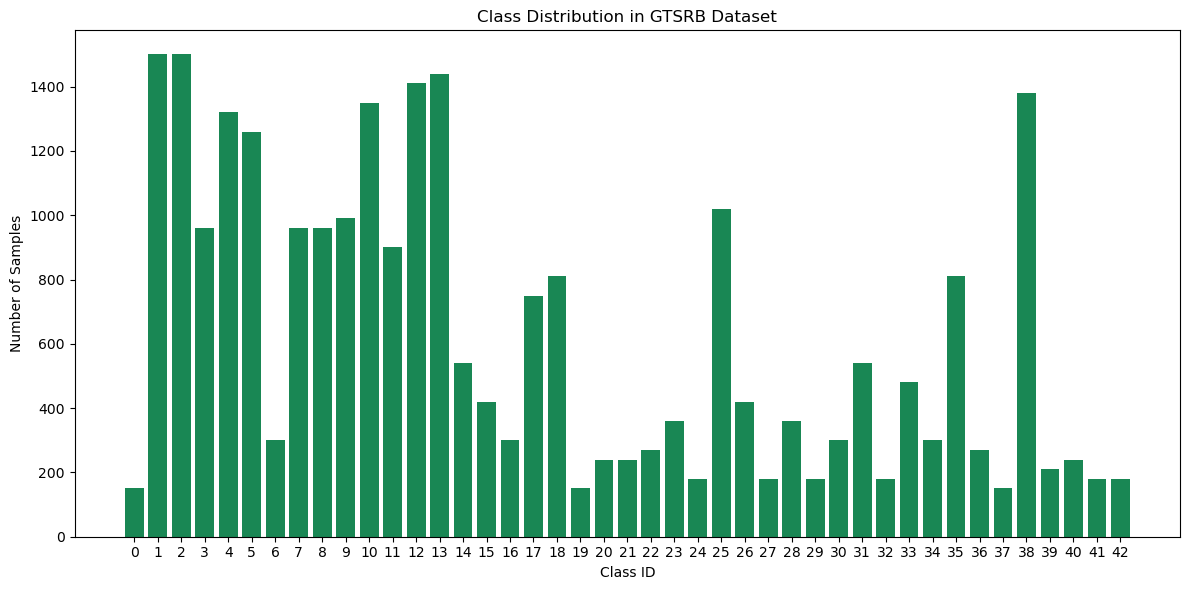

In [8]:
# Get image arrays and labels for all image files
images, labels = load_data("../resources/gtsrb")

# Get class distribution
label_counts = Counter(labels)

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(label_counts.keys(), label_counts.values(), color="#198754")
plt.title("Class Distribution in GTSRB Dataset")
plt.xlabel("Class ID")
plt.ylabel("Number of Samples")
plt.xticks(range(NUM_CATEGORIES))
plt.tight_layout()
plt.savefig("../results/images/class_distribution.png")
plt.show()

# Calculate min, max, total, and percentages
min_class = min(label_counts, key=label_counts.get)
max_class = max(label_counts, key=label_counts.get)
min_count = label_counts[min_class]
max_count = label_counts[max_class]
total = sum(label_counts.values())

# Print summary
summary_html = (
    f'<div class="caption" style="display:flex;justify-content:center;align-items:center;text-align:center;">'
    f'<em>Some classes are 10× more common than others. Individual classes contain from '
    f'<b>{min_count}</b> to <b>{max_count}</b> samples, for a total of <b>{total}</b> images.</em>'
    f'</div>'
)
display(HTML(summary_html))

# Spacer
display(HTML('<div class="spacer"></div>'))

# Display Representative Images of All 43 Traffic Signs
display(HTML('''
<div style="max-width:900px;margin:auto;">
  <img src="../static/images/GTSRB_representatives.png" class="img-soft-border" alt="Traffic Sign Grid" style="width:100%;">
</div>
'''))

<p class="caption" style="display:flex;justify-content:center;align-items:center;text-align:center;">
    <em
    >A real-world example of each class, in order, taken directly from the GTSRB dataset. Signs may differ slightly in color, shape, or condition from their pictorial counterparts. See the <a href="../templates/visual_key.html">Visual Key</a> for a full reference to all sign classes.
    </em>
</p>

<a id="model-architecture"></a>

# Model Architecture

[Back to Top](#)

Models were developed sequentially, beginning with a baseline and progressively adding complexity. Key modifications included: class weighting to mitigate imbalance; additional convolutional layers for richer feature extraction; batch normalization to stabilize training and improve calibration; and additional dense layers, which in practice reduced performance.

The seven models implemented were:
1. Baseline Model
2. Baseline Model + Class Weights
3. Baseline Model + Second Conv Layer
4. Baseline Model + Batch Normalization
5. Baseline Model + Second Conv Layer + Batch Normalization (best performing)
6. Baseline Model + Second Conv Layer + Dense Layer
7. Baseline Model + Second Conv Layer + Dense Layer + Batch Normalization

Each component played a distinct role in shaping performance. Convolutional layers expanded the network’s ability to capture complex visual patterns, while batch normalization reduced internal variance, improving stability and generalization. Class weighting helped protect minority classes from being overshadowed by frequent categories. Dense layers, while theoretically enabling deeper decision boundaries, tended to disrupt calibration and reduce confidence when convolutional features were already strong.

All models were trained on the GTSRB training set and evaluated on a held-out validation/test split. Inputs were resized to 30×30, balancing detail with efficiency. Training used categorical cross-entropy loss with the Adam optimizer and early stopping to prevent overfitting. Accuracy served as the primary benchmark, supplemented by class-level precision, recall, and F1-scores to capture performance across all 43 categories.

In [9]:
# Baseline, inspired by MNIST example
# Run twice, the second time with class weights, to help with imbalanced classes
def Baseline():
    """
    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a Sequential model (starting with MNIST example)
    model = tf.keras.Sequential(
        [
            # Convolution detects the signal from the noise in images
            # by applying filters and amplifying the important features
            # ---
            # Convolutional layer (2D) with 32 filters, 3x3 kernel, ReLU activation
            # 32 filters: pattern detectors (edges, colors, shapes, etc.)
            # Kernel: Slides over 3x3 pixel regions, computing a weighted sum to highlight features
            # ReLU: Zeros negative values on filters, so triggered filters can add up
            # instead of canceling each other out
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
            ),
            # Max-pooling keeps the strongest features while reducing the data size
            # 2x2 pool size: takes the maximum of each 2x2 block of pixels
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Flattening turns the square image into a single long line of neurons
            tf.keras.layers.Flatten(),
            # Dense layer, fully connected, all 128 of them
            # Every neuron weighs every incoming flattened neuron
            tf.keras.layers.Dense(128, activation="relu"),
            # Dropout randomly turns off neurons to prevent overfitting
            # Applied only to the immediately preceding (Dense) layer
            tf.keras.layers.Dropout(0.5),
            # Output layer: one neuron per category
            # Softmax: converts outputs into probabilities summing to 1
            # The category with the highest probability is the model's prediction
            tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        # Adam: adaptive optimizer that adjusts the learning rate throughout training
        optimizer="adam",
        # categorical_crossentropy: penalizes the model when it gives low probability to the correct class
        # e.g., if a cat image is predicted as 60% cat, 20% dog, 10% rabbit, 10% llama, the loss will be high
        loss="categorical_crossentropy",
        # Metric for evaluation: simple accuracy (fraction of correct predictions)
        metrics=["accuracy"],
    )

    return model

In [10]:
# Two convolutional layers
# The first layer finds simple features like edges and colors
# The second layer combines those features to find more complex patterns
# Like corners, shapes, or sign symbols
def Two_Convolutional_Layers():
    """
    Add a second convolutional layer to the baseline.

    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a Sequential model
    model = tf.keras.Sequential(
        [
            # Convolutional layer. Learn 32 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
            ),
            # Max-pooling layer, using 2x2 pool size
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Second Convolutional layer. Learn 64 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Flatten units
            tf.keras.layers.Flatten(),
            # Add a hidden layer with dropout
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            # # Add an output layer with output units for all categories
            tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [11]:
# Baseline with batch normalization
# Normalizes the outputs of a previous layer to have similar distributions (0 mean, 1 stddev)
# Puts all outputs on a level playing field
# Speeds up training, reduces risk of overfitting, allows use of higher learning rates
def Baseline_with_Batch_Normalization():
    """
    Add Batch Normalization to the baseline.

    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a Sequential model
    model = tf.keras.Sequential(
        [
            # Convolutional layer. Learn 32 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
            ),
            # Batch Normalization layer
            tf.keras.layers.BatchNormalization(),
            # Max-pooling layer, using 2x2 pool size
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Flatten units
            tf.keras.layers.Flatten(),
            # Add a hidden layer with dropout
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            # # Add an output layer with output units for all categories
            tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [12]:
# Two convolutional layers with batch normalization
# Hoping to get the benefits of both
def Two_Convolutional_with_Batch_Normalization():
    """
    Add a second convolutional layer and batch normalization to the baseline.

    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a Sequential model
    model = tf.keras.Sequential(
        [
            # Convolutional layer. Learn 32 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
            ),
            # Batch Normalization layer
            tf.keras.layers.BatchNormalization(),
            # Max-pooling layer, using 2x2 pool size
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Second Convolutional layer. Learn 64 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Flatten units
            tf.keras.layers.Flatten(),
            # Add a hidden layer with dropout
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            # # Add an output layer with output units for all categories
            tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [13]:
# Two convolutional + dense layers
# A second Dense layer to learn more complex combinations of features
# Potentially better performance, but also more prone to overfitting
# It's an experiment! For Science!
def Two_Convolutional_and_Dense_Layers():
    """
    Adds a second convolutional layer and a second Dense layer to the baseline.

    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a Sequential model (starting with MNIST example)
    model = tf.keras.Sequential(
        [
            # Convolutional layer. Learn 32 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
            ),
            # Max-pooling layer, using 2x2 pool size
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Second convolutional layer (2D) with 64 filters, 3x3 kernel, ReLU activation
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Flatten units
            tf.keras.layers.Flatten(),
            # Add two hidden layers with dropout
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            # Add an output layer with output units for all categories
            tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [14]:
# Two convolutional + dense layers with batch normalization
def Two_Convolutional_and_Dense_Layers_with_Batch_Normalization():
    """
    Adds a second convolutional layer, a second Dense layer, and batch normalization to the baseline.

    Returns a compiled convolutional neural network model. Assume that the
    `input_shape` of the first layer is `(IMG_WIDTH, IMG_HEIGHT, 3)`.
    The output layer should have `NUM_CATEGORIES` units, one for each category.
    """
    # Create a Sequential model (starting with MNIST example)
    model = tf.keras.Sequential(
        [
            # Convolutional layer. Learn 32 filters using a 3x3 kernel
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)
            ),
            # Batch Normalization layer
            tf.keras.layers.BatchNormalization(),
            # Max-pooling layer, using 2x2 pool size
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Second convolutional layer (2D) with 64 filters, 3x3 kernel, ReLU activation
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
            # Flatten units
            tf.keras.layers.Flatten(),
            # Add two hidden layers with dropout
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            # Add an output layer with output units for all categories
            tf.keras.layers.Dense(NUM_CATEGORIES, activation="softmax"),
        ]
    )

    # Compile the model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

In [15]:
# Display banner image
display(HTML('''
<div style="max-width:900px;margin:auto;">
  <img src="../static/images/GTSRB_banner.png" class="img-soft-border" alt="Traffic Signs Banner" style="width:100%;">
</div>
'''))

<a id="training-and-evaluation"></a>

# Training and Evaluation Outputs

[Back to Top](#)

The following outputs summarize training and evaluation results for each model:

#### Model Summary  
- Each evaluation begins with a brief recap of the model’s architecture, highlighting which modifications are active.

#### Training and Loss Curves  
- Accuracy and loss curves track learning over time. With Dropout active, validation metrics may surpass training. Smooth convergence suggests stable learning; divergence signals overfitting or regularization effects.

#### Confusion Matrix  
- Confusion matrices plot predicted vs. true labels across all 43 classes. Most cells are empty; performance is judged by the sharpness of the diagonal. Off-diagonal errors highlight confusion among visually similar categories, especially within the upper-left speed-limit cluster.

#### Classification Report  
- Reports show precision, recall, F1-score, and support for each class. Comparing majority vs. minority categories reveals whether rare signs are recognized reliably or collapse into false negatives. Weighted averages summarize overall performance.

#### Error & Misclassification Analysis  
- Grids of the most frequent misclassifications display the true label, predicted label, and model confidence. Any blurriness reflects convolutional feature extraction, not dataset quality. A text summary reports total misclassifications and the top error types (commonly confusion between similar speed limits). A histogram of misclassification confidence distinguishes uncertain errors from systematic blind spots.

Together, these outputs provide a detailed view of each model’s behavior, setting the stage for cross-model comparison.

In [16]:
# Get image arrays and labels for all image files
# Loaded above, under Class Distribution
# images, labels = load_data("./resources/gtsrb")

# Split data into training and testing sets
labels = tf.keras.utils.to_categorical(labels)

# First split: train vs. temp (val+test)
x_train, x_temp, y_train, y_temp = train_test_split(
    np.array(images), np.array(labels), test_size=0.4, random_state=42
)
# Second split: val vs. test (split temp into val and test)
x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42
)


# Train and evaluate model function
def train_and_evaluate(
    model_fn,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    epochs=10,
    early_stopping=False,
    use_class_weight=False,
    model_name=None,
):
    # Extract model name from function if not provided
    if model_name is None:
        model_name = model_fn.__name__

    # Callbacks for training
    callbacks = []
    # Early stopping callback
    if early_stopping:
        callbacks.append(
            EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
        )
    # Learning rate reduction callback
    callbacks.append(
        ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6)
    )

    # Compute class weights if needed
    class_weight = None
    if use_class_weight:
        y_train_labels = y_train.argmax(axis=1)
        class_weight_values = compute_class_weight(
            class_weight="balanced", classes=np.unique(y_train_labels), y=y_train_labels
        )
        class_weight = dict(enumerate(class_weight_values))

    # Build and train the model, evaluate on validation set
    model = model_fn()
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        validation_data=(x_val, y_val),
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=0,
    )
    model.evaluate(x_val, y_val, verbose=0)

    # Plot and save training/validation loss and accuracy curves
    plot_and_save_training_curves(history, model_name)

    # Predict on validation set
    y_pred = model.predict(x_val, verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true = y_val.argmax(axis=1)

    # Confusion matrix
    plot_and_save_confusion_matrix(y_true, y_pred_classes, model_name)

    # Classification report
    save_classification_report(y_true, y_pred_classes, model_name)

    # Show misclassified images
    show_top_misclassifications(
        x_val, y_true, y_pred_classes, y_pred, model_name=model_name
    )

    # Most common misclassifications
    most_common_misclassifications(y_true, y_pred_classes, top_n=5)

    # Misclassification confidence histogram
    plot_misclassification_confidence_histogram(
        y_true, y_pred_classes, y_pred, model_name=model_name
    )

    # Save model summary to text file
    save_model_summary(model, model_name)

    # Save history and the model
    pd.DataFrame(history.history).to_csv(
        f"../results/{model_name}_history.csv", index=False
    )
    model.save(f"../models/{model_name}.h5")
    # print(f"Model saved to {model_name}.h5")

<a id="baseline-model"></a>

## Baseline Model

[Back to Top](#)

The baseline architecture follows the classic MNIST CNN structure. It consists of a single convolutional layer with 32 filters (3×3 kernel, ReLU activation) followed by max pooling to reduce spatial dimensions. The extracted features are flattened and passed through a dense layer of 128 units with ReLU activation, regularized by a dropout layer (0.5). The final softmax layer outputs probabilities across all 43 traffic sign categories.

This model was run twice: once with standard categorical cross-entropy loss, and again with class weights applied to address dataset imbalance. The latter ensures that rare classes (e.g., uncommon signs) receive proportionally more influence during training, reducing the risk of the model defaulting to majority categories such as common speed limits.

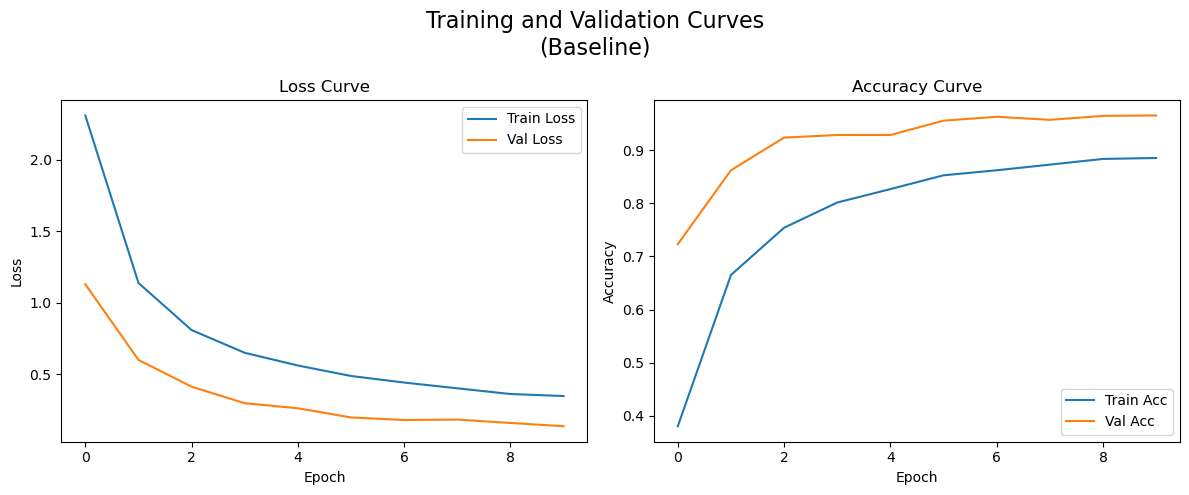

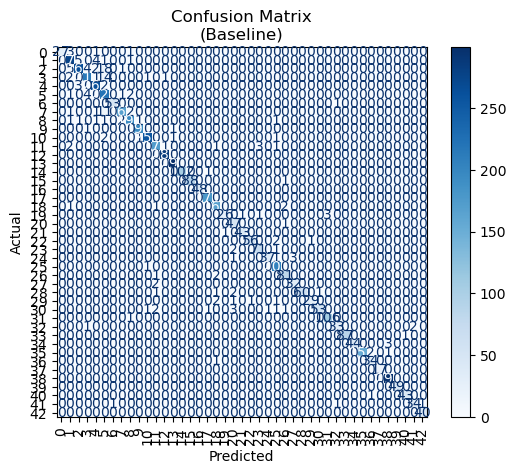

,precision,recall,f1-score,support
accuracy,0.965653,0.965653,0.965653,0.965653
macro avg,0.967660,0.955663,0.960694,5328.000000
weighted avg,0.967178,0.965653,0.965741,5328.000000
0,1.000000,0.843750,0.915254,32.000000
1,0.945017,0.961538,0.953206,286.000000
2,0.967033,0.897959,0.931217,294.000000
3,0.955752,0.919149,0.937093,235.000000
4,0.963370,0.981343,0.972274,268.000000
5,0.817844,0.964912,0.885312,228.000000
6,0.981481,0.981481,0.981481,54.000000


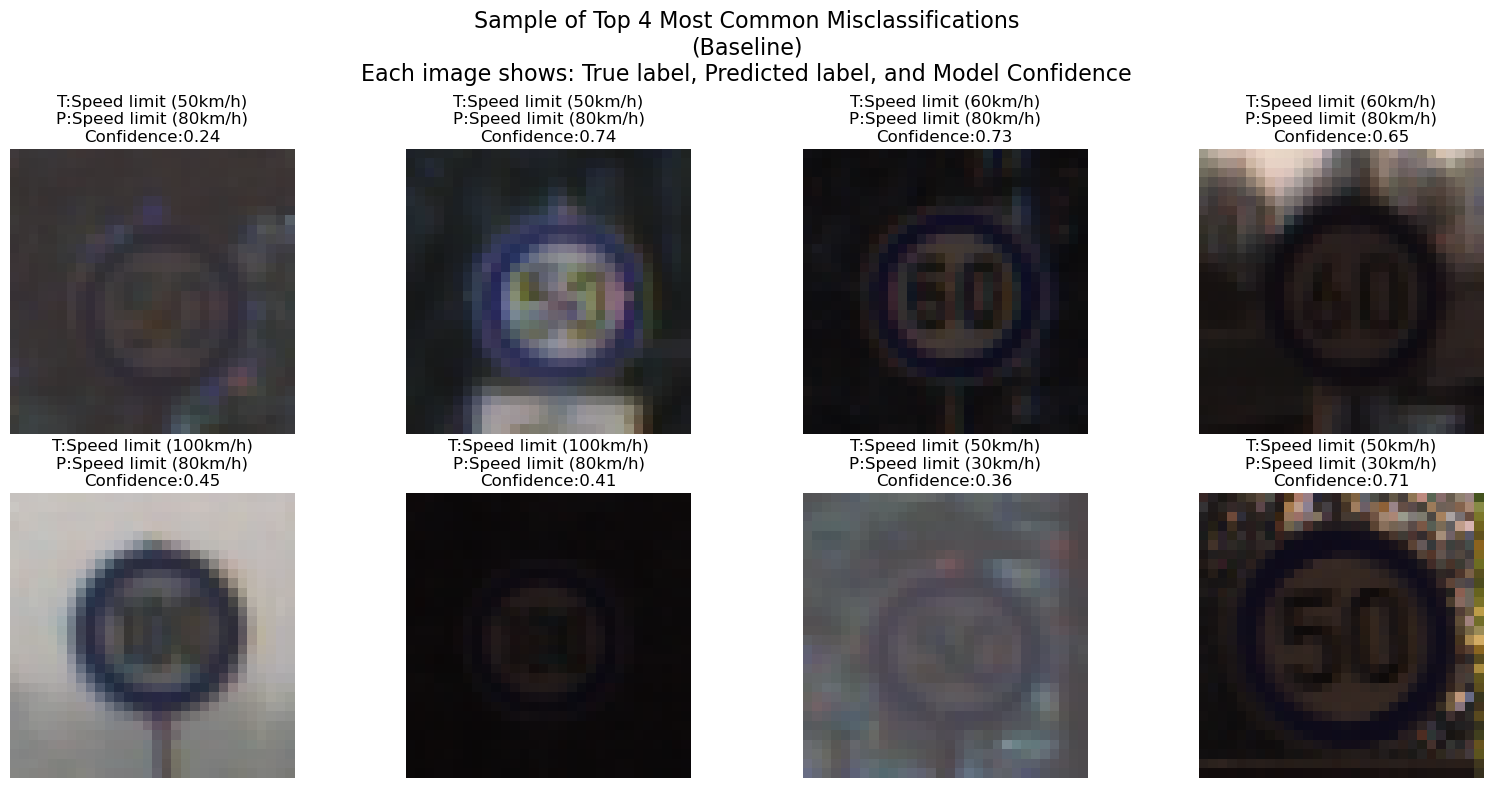

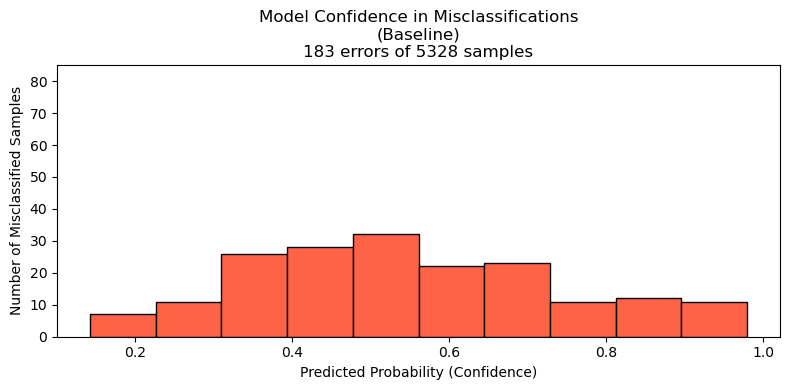

In [17]:
# Evaluate baseline model
train_and_evaluate(Baseline)

### Results for Baseline Model

The baseline model provides a strong foundation, achieving 96.6% accuracy, with weighted precision, recall, and f1-scores all in the 0.96–0.97 range. While this marks a solid starting point, the results leave clear room for improvement compared to later architectures.

Performance is generally high across most classes, with many achieving precision and recall above 0.95, including several minority categories (e.g., classes 6, 16, 37, 39). However, some weaknesses are apparent. Class 5, representing speed limit signs, is especially problematic: precision falls to 0.82, the lowest among major classes, as the model produces many false positives when confusing visually similar signs (speed limit signs with different numeric values). Other mid-sized classes also show inconsistency, such as class 20 (precision 0.84) and class 30 (recall 0.84). Minority classes are hit-or-miss: some achieve perfect scores, while others (e.g., class 19 with recall 0.84, class 29 with recall 0.85) lag behind.

Training and validation curves show a small gap, likely due to dropout being active during training rather than genuine overfitting. The confidence histogram appears well-calibrated, with predictions spread smoothly across probability bins rather than clustering too sharply at the extremes.

In short, the baseline model demonstrates robust performance but struggles with class imbalance and visually similar categories. These results highlight the need for architectural refinements—such as additional convolutional layers or batch normalization—to boost generalization and reduce systematic errors.

<a id="baseline-model-with-class-weights"></a>

## Baseline Model with Class Weights

[Back to Top](#)

The baseline architecture follows the classic MNIST CNN structure. It consists of a single convolutional layer with 32 filters (3×3 kernel, ReLU activation) followed by max pooling to reduce spatial dimensions. The extracted features are flattened and passed through a dense layer of 128 units with ReLU activation, regularized by a dropout layer (0.5). The final softmax layer outputs probabilities across all 43 traffic sign categories.

This is the model's second run, with class weights applied to address dataset imbalance. This ensures that rare classes (e.g., uncommon signs) receive proportionally more influence during training, reducing the risk of the model defaulting to majority categories such as common speed limits. While performance gains on minority classes were noticeable, the model delivered slightly reduced accuracy overall, highlighting design tradeoffs.

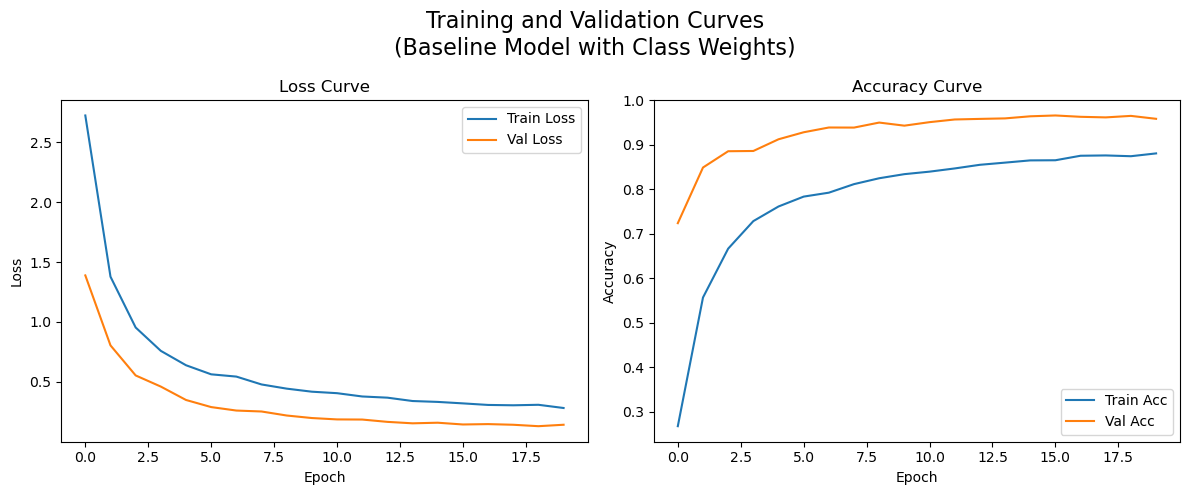

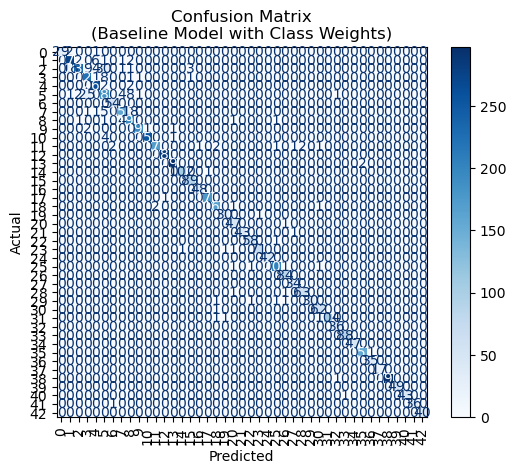

,precision,recall,f1-score,support
accuracy,0.958333,0.958333,0.958333,0.958333
macro avg,0.967206,0.969188,0.967458,5328.000000
weighted avg,0.960015,0.958333,0.958143,5328.000000
0,1.000000,0.906250,0.950820,32.000000
1,0.935154,0.958042,0.946459,286.000000
2,0.978723,0.782313,0.869565,294.000000
3,0.857692,0.948936,0.901010,235.000000
4,0.953069,0.985075,0.968807,268.000000
5,0.784810,0.815789,0.800000,228.000000
6,0.947368,1.000000,0.972973,54.000000


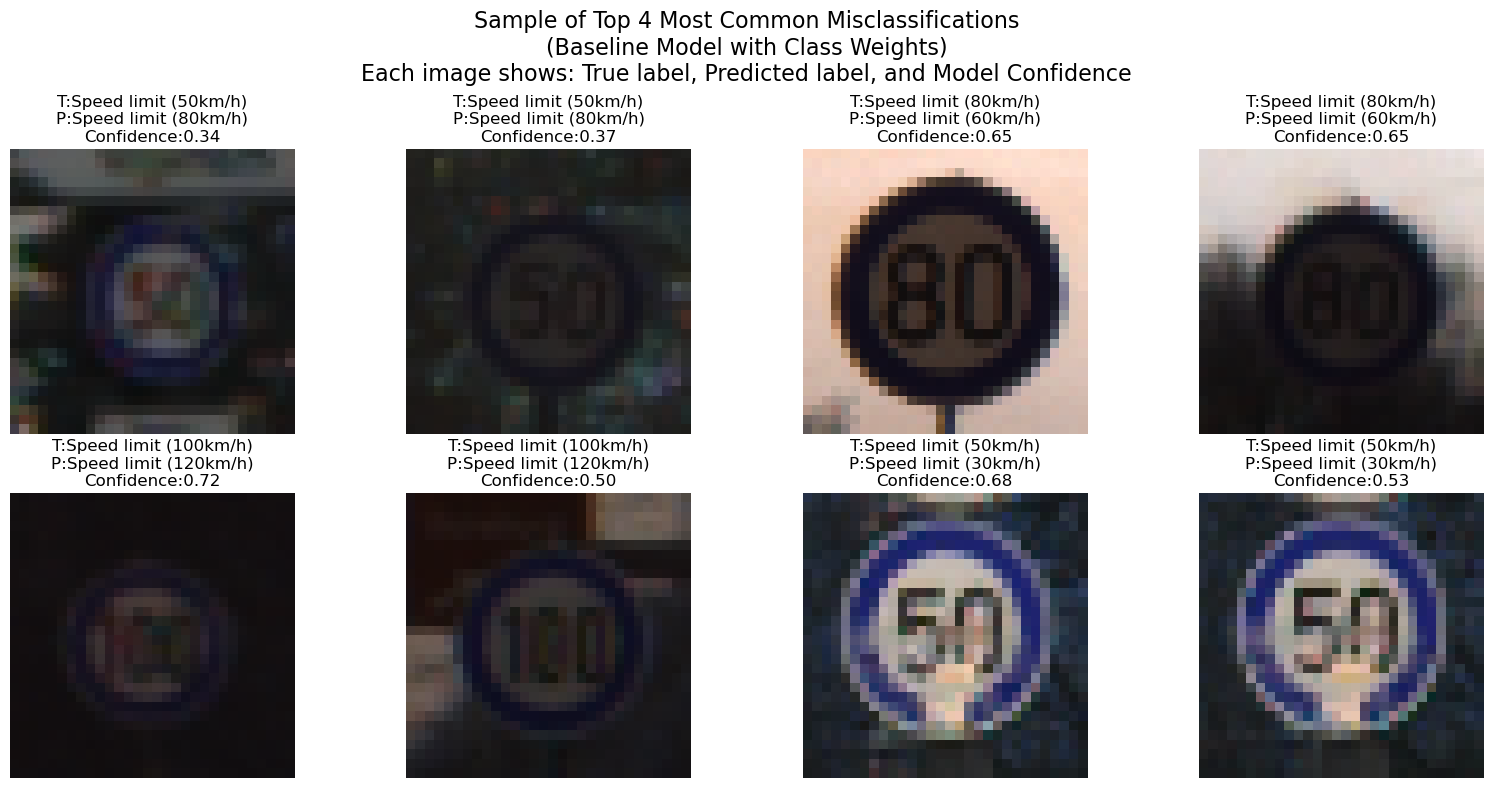

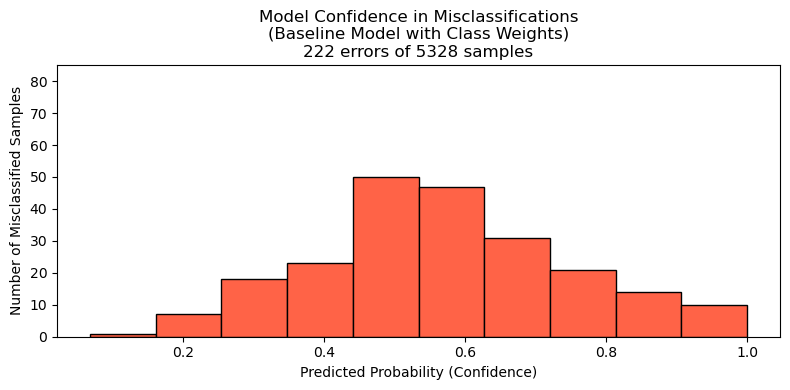

In [18]:
# Evaluate baseline model with class weights
train_and_evaluate(
    Baseline,
    epochs=20,
    early_stopping=True,
    use_class_weight=True,
    model_name="Baseline_Model_with_Class_Weights",
)

### Results for Baseline Model with Class Weights

The baseline model with class weights reaches 95.8% overall accuracy, with weighted precision, recall, and f1-score all close to 0.96. This is slightly lower than the unweighted baseline, but still demonstrates strong performance.

Applying class weights appears to have shifted trade-offs between precision and recall. In the majority, for example, class 2 shows noticeably lower recall (0.78) despite very high precision (0.98), while classes such as 3 and 8 achieve higher recall (~0.95) at the cost of precision (0.86). Several minority classes (e.g., 24, 27, 32, 34, 36, 42) now achieve perfect or near-perfect scores, suggesting that weighting helped the model attend more to underrepresented categories.

Class 5 continues to be problematic, with both lower precision (0.82 to 0.78) and recall (0.96 to 0.82) compared to the baseline model, indicating that speed limit signs remain a source of confusion even with weighting.

The overall calibration of predictions remains balanced, with no clear evidence of systematic overconfidence or underconfidence.

In short, class weighting improved performance on many minority classes but slightly reduced overall accuracy and consistency, highlighting the trade-off between global performance and minority class support.

<a id="two-convolutional-layers"></a>

## Two Convolutional Layers

[Back to Top](#)

Building on the baseline, this architecture introduces a second convolutional layer (64 filters, 3×3 kernel, ReLU) after the first convolution + pooling block. The additional layer allows the network to detect more complex feature hierarchies, such as corners, shapes, or traffic sign symbols, beyond the simple edges and colors captured in the first layer.

After feature extraction, the architecture mirrors the baseline: flattening, a dense layer of 128 units with dropout (0.5), and a final softmax classification layer. This model increases representational capacity while maintaining regularization to guard against overfitting.

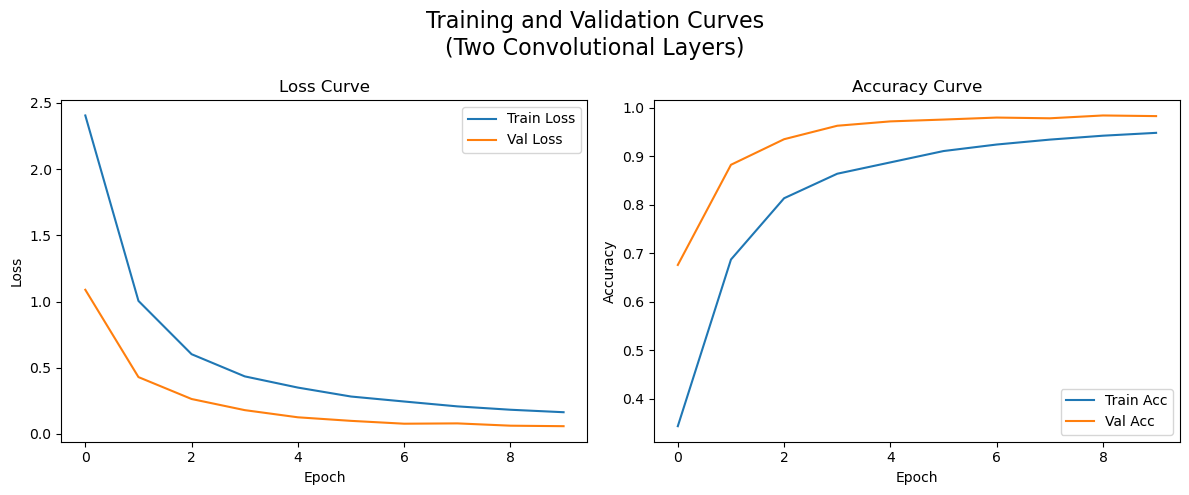

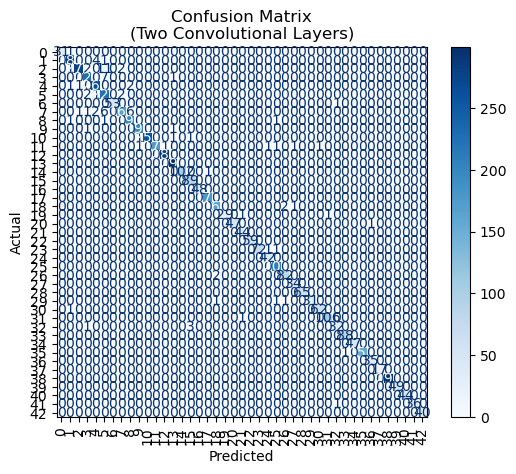

,precision,recall,f1-score,support
accuracy,0.982733,0.982733,0.982733,0.982733
macro avg,0.984688,0.982062,0.983111,5328.000000
weighted avg,0.983218,0.982733,0.982749,5328.000000
0,1.000000,0.968750,0.984127,32.000000
1,0.982517,0.982517,0.982517,286.000000
2,0.992857,0.945578,0.968641,294.000000
3,0.970085,0.965957,0.968017,235.000000
4,0.974170,0.985075,0.979592,268.000000
5,0.895582,0.978070,0.935010,228.000000
6,1.000000,0.981481,0.990654,54.000000


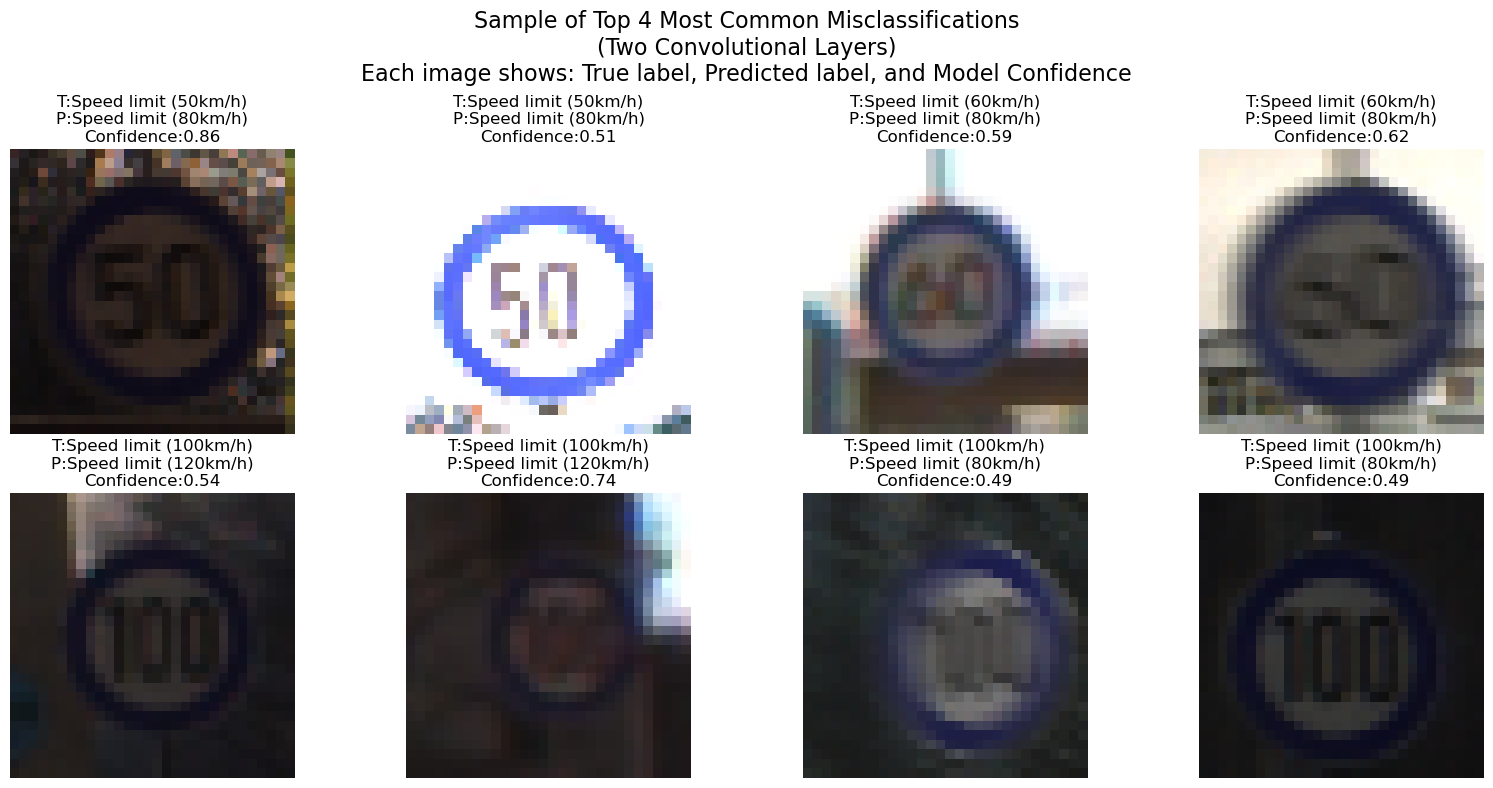

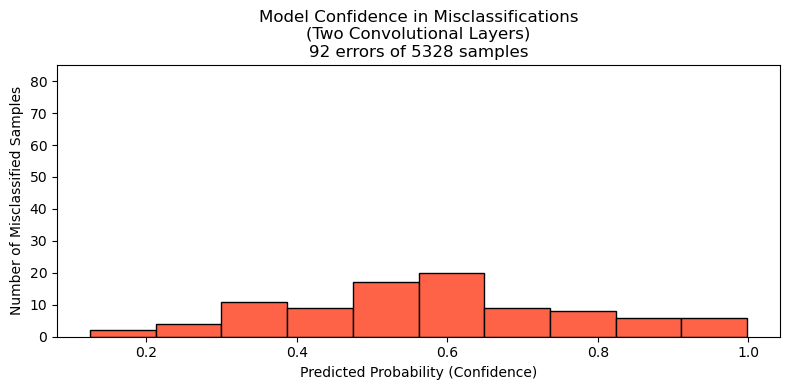

In [19]:
# Evaluate two-convolutional-layer model
train_and_evaluate(Two_Convolutional_Layers)

### Results for Two Convolutional Layers

Adding a second convolutional layer significantly improves performance, with overall accuracy rising to 98.3% (vs. 96.6% for the baseline and 95.8% with class weights). Weighted precision, recall, and f1-score all hover around 0.98, marking a clear step up in generalization.

This model shows strong improvements in previously weaker classes. For example, class 5 (a common source of confusion among similar speed limit signs) improves from precision 0.82 (baseline) and 0.78 (Weighted) to 0.90, with recall climbing as high as 0.98. Other historically tricky categories like classes 19, 20, 24, 29, and 30 also report near-perfect metrics, often achieving both precision and recall above 0.95.

Nearly all minority classes reach perfect scores (precision, recall, f1 = 1.00), suggesting the deeper convolutional structure better captures subtle features even with limited data. Only a few small classes (e.g., 32 with f1 = 0.91) still lag slightly.

In short, the additional convolutional layer boosts feature extraction capacity, leading to higher accuracy, stronger minority class performance, and more consistent predictions across the full label set. This architecture outperforms both the baseline and class weighted models without signs of overfitting.

<a id="baseline-model-with-batch-normalization"></a>

## Baseline Model with Batch Normalization

[Back to Top](#)

This variant augments the baseline with batch normalization after the initial convolutional layer. Batch normalization standardizes intermediate outputs, keeping activations on a consistent scale across batches. This has three benefits: (1) stabilizing training, (2) reducing sensitivity to initialization and learning rates, and (3) improving generalization.

The rest of the architecture mirrors the baseline: one convolutional layer (32 filters), pooling, flattening, a dense layer of 128 units with dropout, and softmax output.

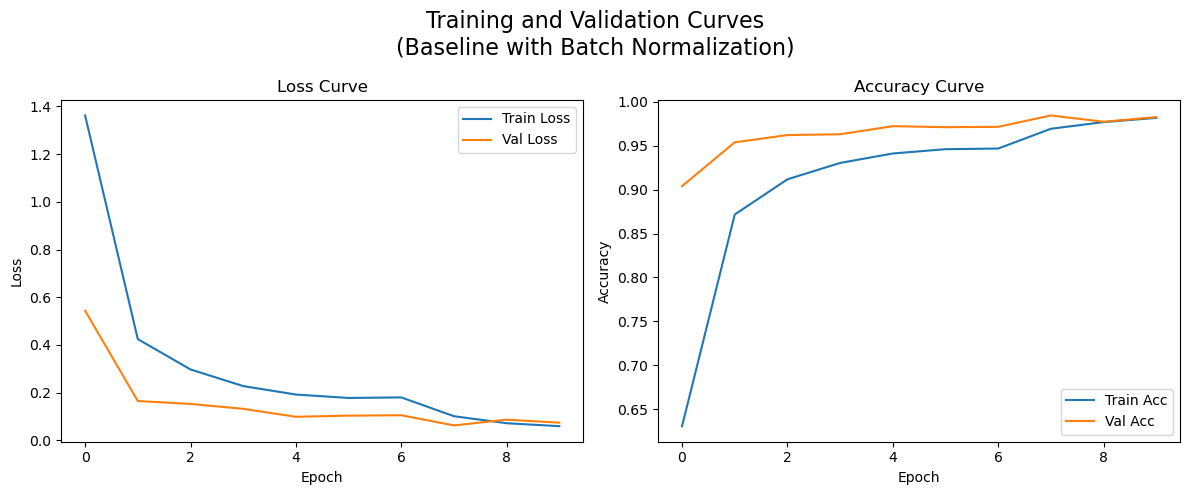

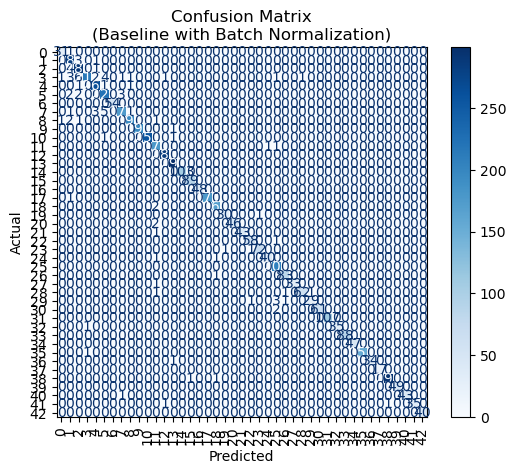

,precision,recall,f1-score,support
accuracy,0.982545,0.982545,0.982545,0.982545
macro avg,0.986344,0.978723,0.982302,5328.000000
weighted avg,0.982805,0.982545,0.982484,5328.000000
0,0.939394,0.968750,0.953846,32.000000
1,0.952703,0.986014,0.969072,286.000000
2,0.956954,0.982993,0.969799,294.000000
3,0.990741,0.910638,0.949002,235.000000
4,0.974265,0.988806,0.981481,268.000000
5,0.952586,0.969298,0.960870,228.000000
6,1.000000,1.000000,1.000000,54.000000


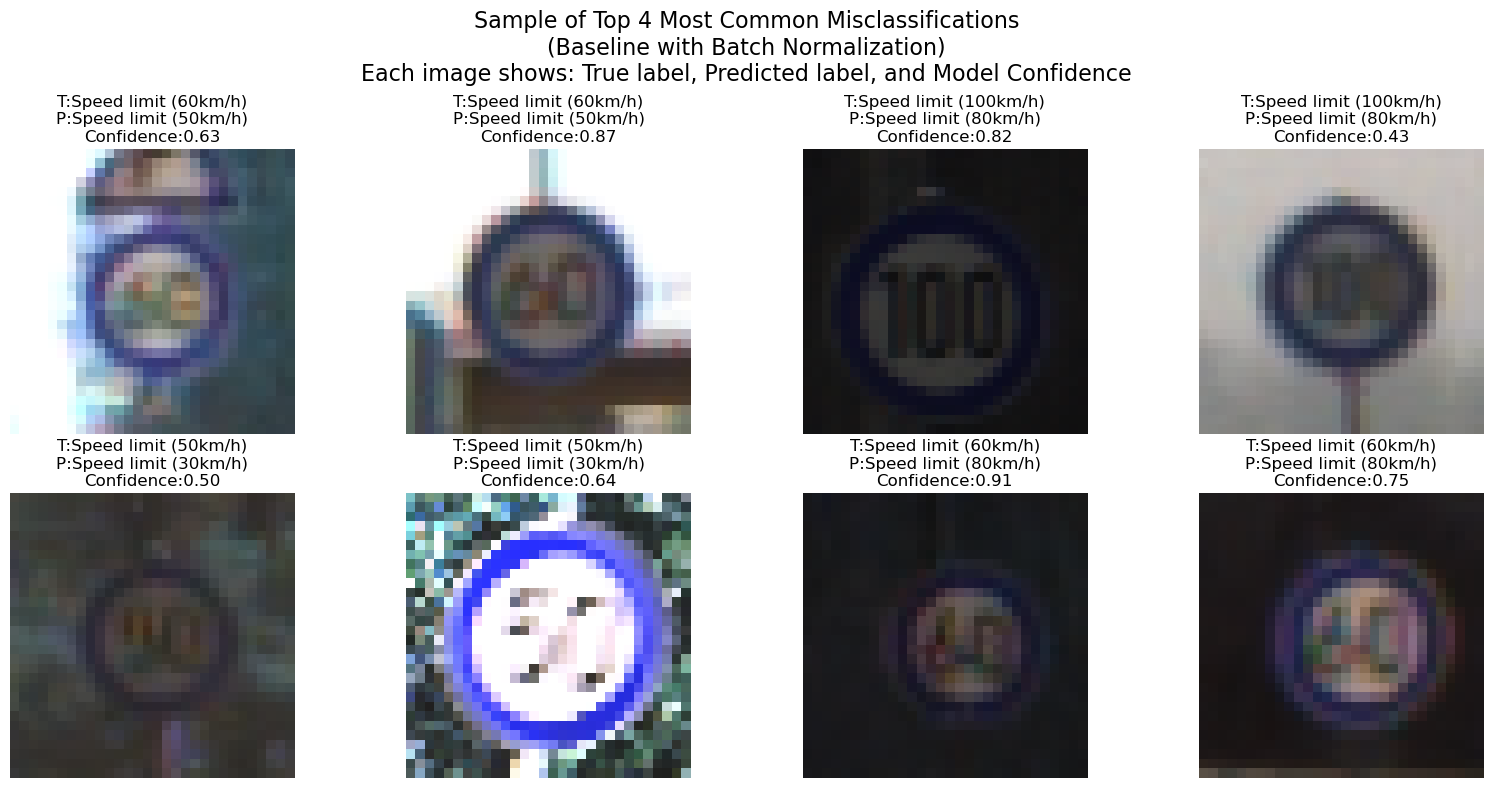

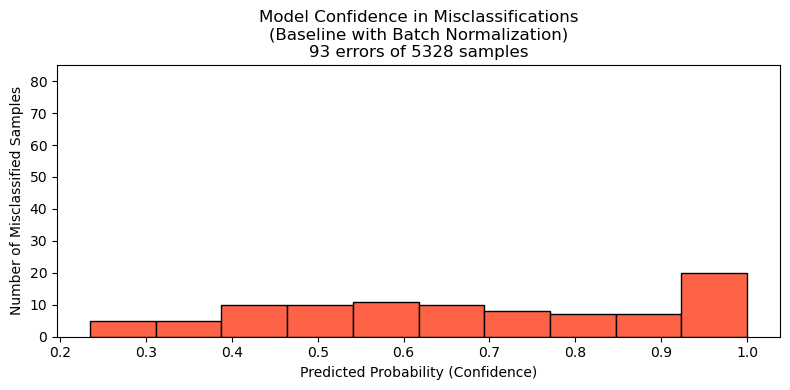

In [20]:
# Evaluate baseline model with batch normalization
train_and_evaluate(Baseline_with_Batch_Normalization)

### Results for Baseline Model with Batch Normalization

Introducing batch normalization yields excellent performance, with overall accuracy of 98.3%, nearly identical to the two-convolutional-layer model. Weighted precision, recall, and f1-score are all ~0.983, representing a clear improvement over both the original baseline (96.6%) and the baseline with class weights (95.8%).

Unlike the two-convolutional-layer model, which relied on deeper feature extraction, Batch normalization stabilizes training and leads to faster convergence: the training and validation loss curves align closely, suggesting a well-regularized model with little overfitting.

Performance across classes is broadly consistent, with most precision, recall, and f1-scores above 0.95. Notably, class 5 improves dramatically (precision 0.95, recall 0.97, f1 = 0.96), resolving much of the false-positive issue seen in the baseline (precision 0.82) and Weighted (0.78) models. Minority classes also remain robust, with several (e.g., classes 6, 16, 34, 37, 39, 42) achieving perfect scores. A few smaller classes (e.g., 29 with f1 = 0.91) still lag slightly, though less than before.

One distinction is seen in the confidence histogram: Batch normalization leads to a sharp spike near 0.9–1.0 predicted probabilities, suggesting the model is more confident in its predictions compared to the smoother distribution of the baseline. This does not appear to harm calibration, as misclassifications are fewer and more isolated.

Overall, batch normalization proves as effective as architectural deepening for boosting performance, with the added benefit of improved convergence and stability during training.

<a id="two-convolutional-layers-with-batch-normalization"></a>

## Two Convolutional Layers with Batch Normalization

[Back to Top](#)

This model combines the two main improvements explored so far: **a deeper convolutional stack** and **batch normalization**. The architecture features:

- Conv layer (32 filters, 3×3, ReLU) + batch normalization + max pooling

- Conv layer (64 filters, 3×3, ReLU) + batch normalization + max pooling

- Flatten → Dense (128 units, ReLU) + dropout (0.5) → Softmax output

This design improves both **feature richness** and **training stability**, and ultimately delivered the best overall performance among all tested models.

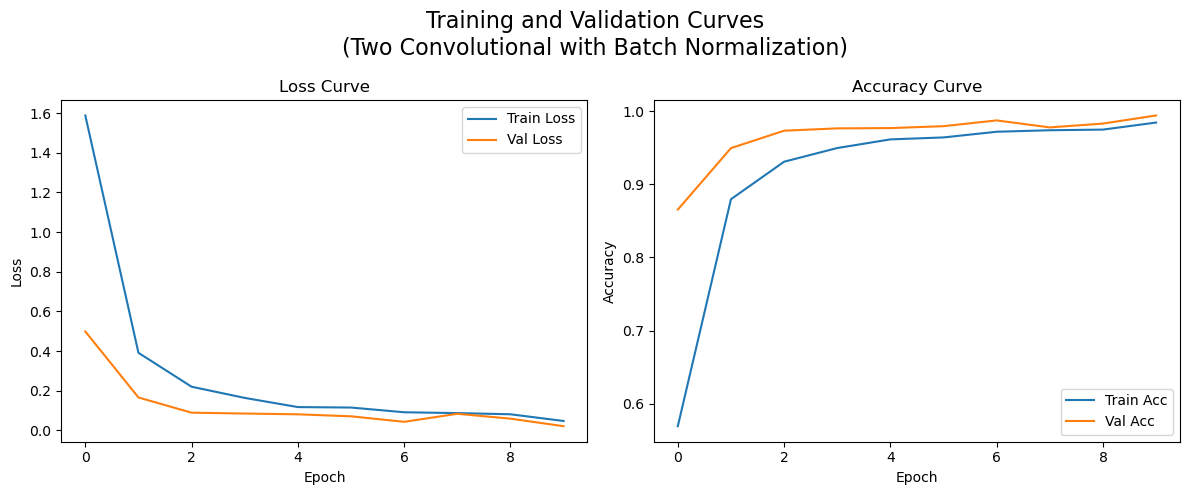

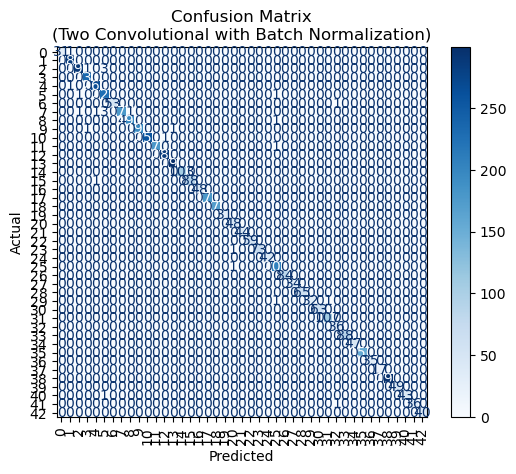

,precision,recall,f1-score,support
accuracy,0.994182,0.994182,0.994182,0.994182
macro avg,0.995007,0.993229,0.994045,5328.000000
weighted avg,0.994251,0.994182,0.994180,5328.000000
0,1.000000,0.968750,0.984127,32.000000
1,0.993056,1.000000,0.996516,286.000000
2,0.993151,0.986395,0.989761,294.000000
3,0.991561,1.000000,0.995763,235.000000
4,0.992565,0.996269,0.994413,268.000000
5,0.969957,0.991228,0.980477,228.000000
6,1.000000,0.981481,0.990654,54.000000


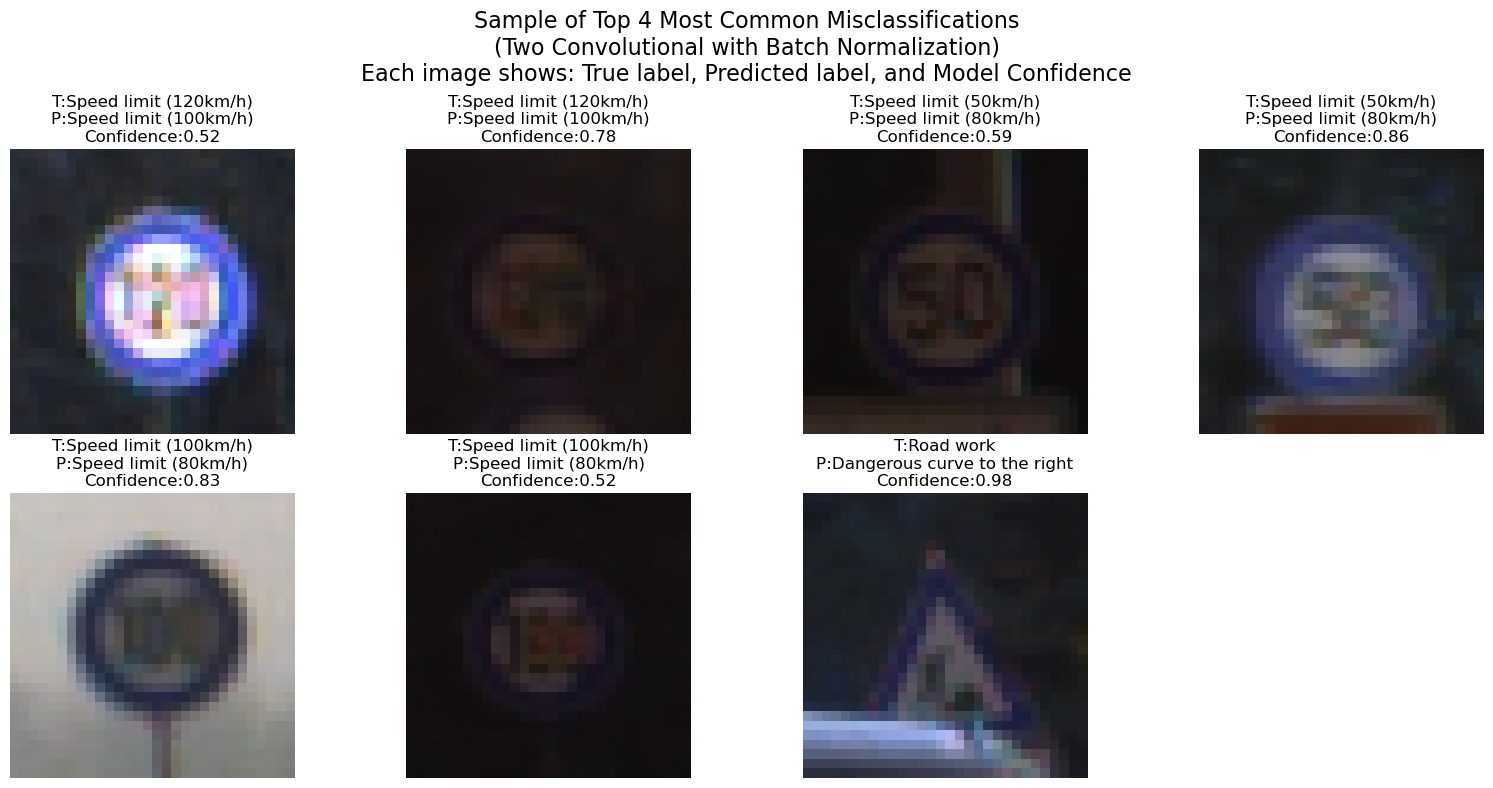

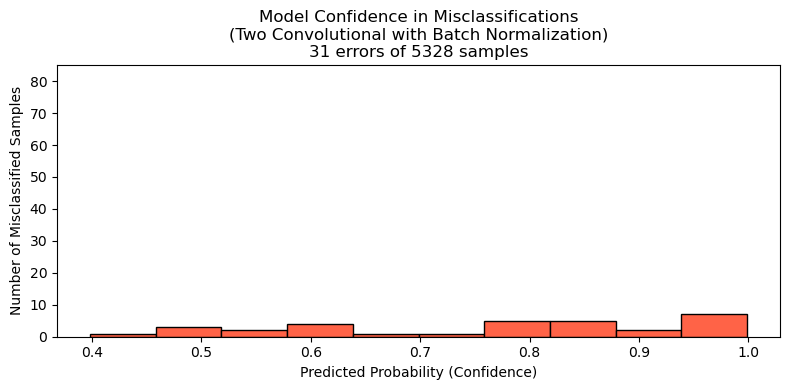

In [21]:
# Evaluate two-convolutional-layer model with batch normalization
train_and_evaluate(Two_Convolutional_with_Batch_Normalization)

### Results for Two Convolutional Layers with Batch Normalization

Combining batch normalization with a two-layer convolutional block produces the strongest results yet, with overall accuracy reaching 99.4%. Weighted precision, recall, and f1-score are all ~0.994, surpassing both the two-convolutional-layer model (98.3%) and baseline with batch normalization (98.3%) models.

This configuration delivers near-perfect performance across almost all classes. The long-standing challenges with speed limit signs (class 5) are largely resolved, achieving precision 0.97 and recall 0.99. Similarly, smaller or previously inconsistent classes such as 19, 20, 29, and 32 now achieve scores at or near 1.00, with only minor deviations (e.g., class 29 f1 = 0.97).

The model’s predictions are not only more accurate but also more confident. Predicted probabilities cluster sharply near 1.0, reflecting highly separable feature representations. While this could suggest overconfidence, the confusion matrix shows almost no systematic misclassifications, indicating that the confidence is well-placed.

In short, combining batch normalization with a deeper convolutional block maximizes both accuracy and stability, virtually eliminating misclassifications and setting a new benchmark for performance on this dataset.

<a id="two-convolutional--dense-layers"></a>

## Two Convolutional + Dense Layers

[Back to Top](#)

This architecture extends the two-convolutional-layer model by adding an additional dense layer after flattening. Specifically:

- Convolutional stack: 32-filter layer + pooling → 64-filter layer + pooling

- Dense (128 units, ReLU) + dropout (0.5)

- Dense (64 units, ReLU) + dropout (0.5)

- Softmax output

The motivation was to allow the network to learn more complex, non-linear combinations of extracted features. While deeper dense stacks can capture subtler decision boundaries, they also increase risk of overfitting, particularly when feature extraction is already strong.

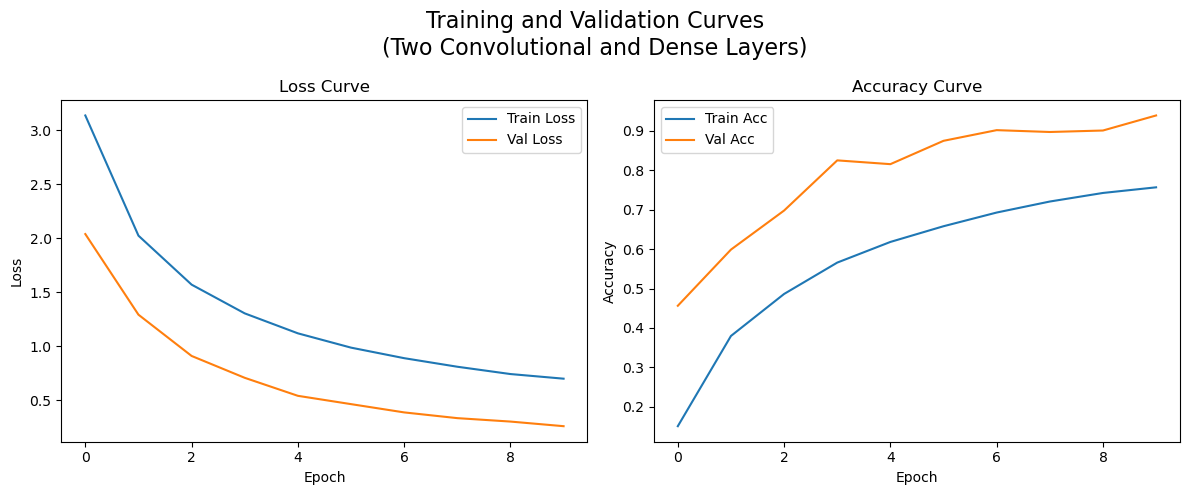

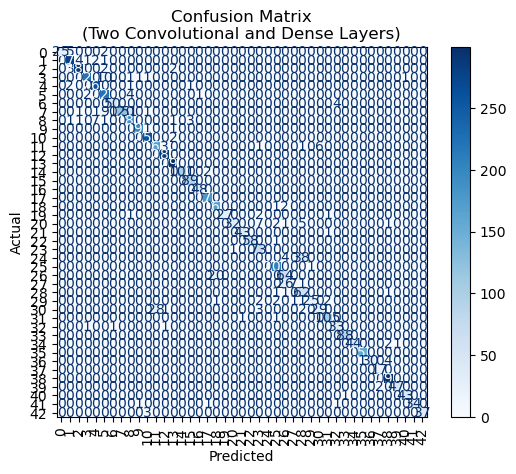

,precision,recall,f1-score,support
accuracy,0.938251,0.938251,0.938251,0.938251
macro avg,0.915974,0.885795,0.890472,5328.000000
weighted avg,0.937184,0.938251,0.932645,5328.000000
0,1.000000,0.781250,0.877193,32.000000
1,0.961938,0.972028,0.966957,286.000000
2,0.979522,0.976190,0.977853,294.000000
3,0.982222,0.940426,0.960870,235.000000
4,0.963504,0.985075,0.974170,268.000000
5,0.898374,0.969298,0.932489,228.000000
6,0.980392,0.925926,0.952381,54.000000


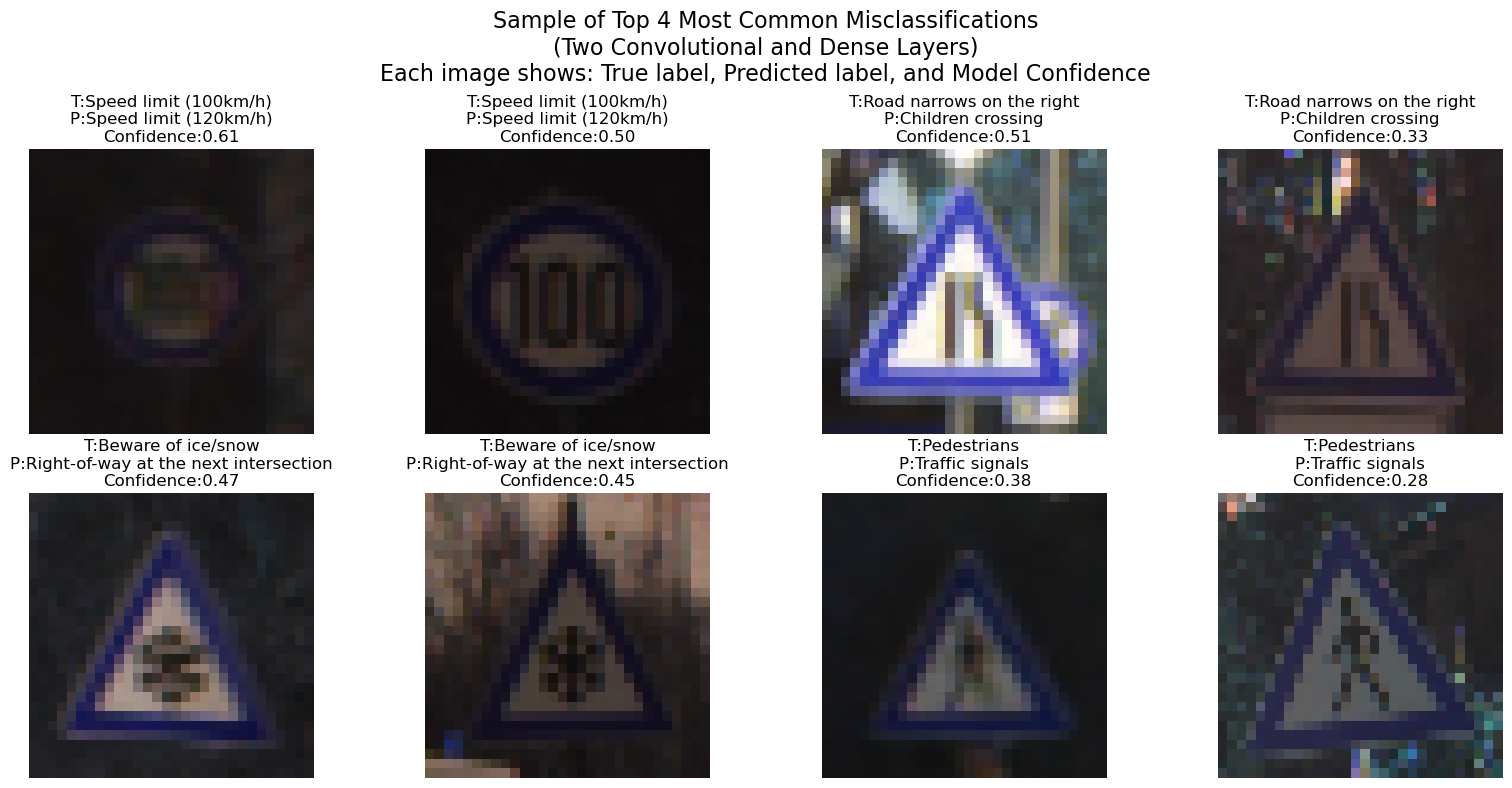

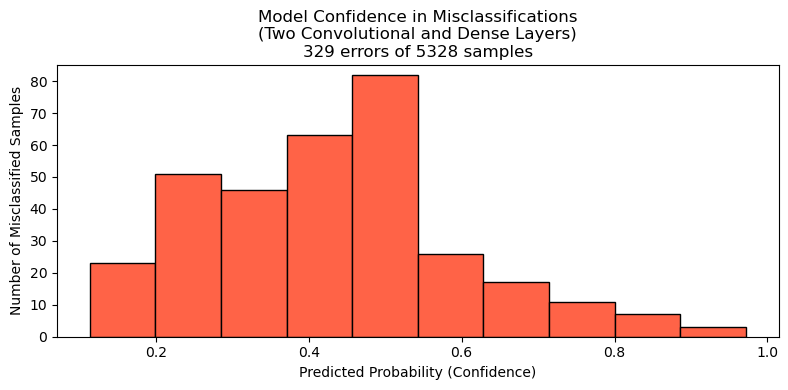

In [22]:
# Evaluate two convolutional + dense layers
train_and_evaluate(Two_Convolutional_and_Dense_Layers)

### Results for Two Convolutional + Dense Layers

Adding an extra Dense layer after the two convolutional layers significantly reduces performance compared to earlier models. Overall accuracy drops to 93.8%, with weighted precision, recall, and f1-score all in the 0.93 range—noticeably lower than the ~99% achieved by the best-performing convolutional + batch normalization setups.

The added dense layer appears to destabilize training, leading to inconsistent class-level results. Several classes that previously reached near-perfect precision and recall now show severe degradation. For example, class 24 fails completely (precision/recall/f1 = 0.0), class 27 has recall just 0.21, and classes 20, 28, and 30 all fall below 0.80 f1-scores. Even relatively large classes (e.g., class 7 with f1 = 0.79) suffer, suggesting that the dense layer introduced overfitting or disrupted feature generalization.

While some categories (e.g., classes 12, 13, 17, 35) still achieve perfect or near-perfect performance, the overall pattern is one of instability and uneven generalization. Minority classes that had been well-handled in prior models are disproportionately affected, which explains the large gap between macro-average metrics (precision 0.92, recall 0.89) and weighted averages.

In short, the additional dense layer degrades both global accuracy and minority class performance, indicating that architectural complexity at the dense stage does not benefit this task and instead undermines the strong feature extraction already achieved by the convolutional blocks.

<a id="two-convolutional--dense-layers-with-batch-normalization"></a>

## Two Convolutional + Dense Layers with Batch Normalization

[Back to Top](#)

The final variant adds batch normalization to the two-convolution, two-dense model. Normalization layers are applied after each convolutional block, leveling the playing field for subsequent activations.

The architecture is:

- Conv (32 filters, 3×3, ReLU) → BatchNorm → MaxPooling

- Conv (64 filters, 3×3, ReLU) → BatchNorm → MaxPooling

- Flatten → Dense (128 units, ReLU) + Dropout (0.5)

- Dense (64 units, ReLU) + Dropout (0.5)

- Softmax output

This model sought to blend deeper representation power with training stability. While performance gains over the simpler additional Dense variant were noticeable, the design continues to underperform models without the additional complexity.

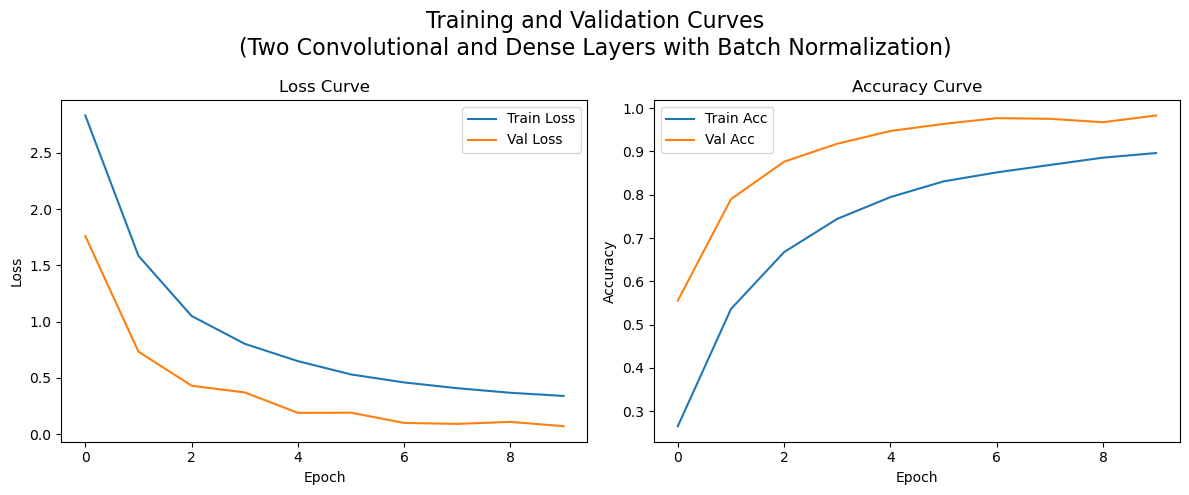

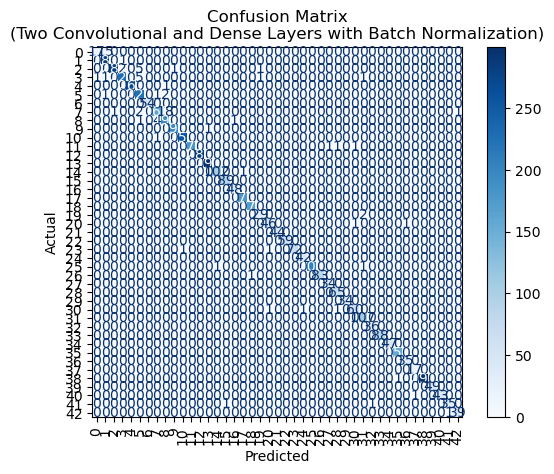

,precision,recall,f1-score,support
accuracy,0.983108,0.983108,0.983108,0.983108
macro avg,0.981243,0.975459,0.976832,5328.000000
weighted avg,0.983436,0.983108,0.982712,5328.000000
0,0.944444,0.531250,0.680000,32.000000
1,0.943709,0.996503,0.969388,286.000000
2,0.996503,0.969388,0.982759,294.000000
3,0.986900,0.961702,0.974138,235.000000
4,1.000000,0.996269,0.998131,268.000000
5,0.945148,0.982456,0.963441,228.000000
6,1.000000,1.000000,1.000000,54.000000


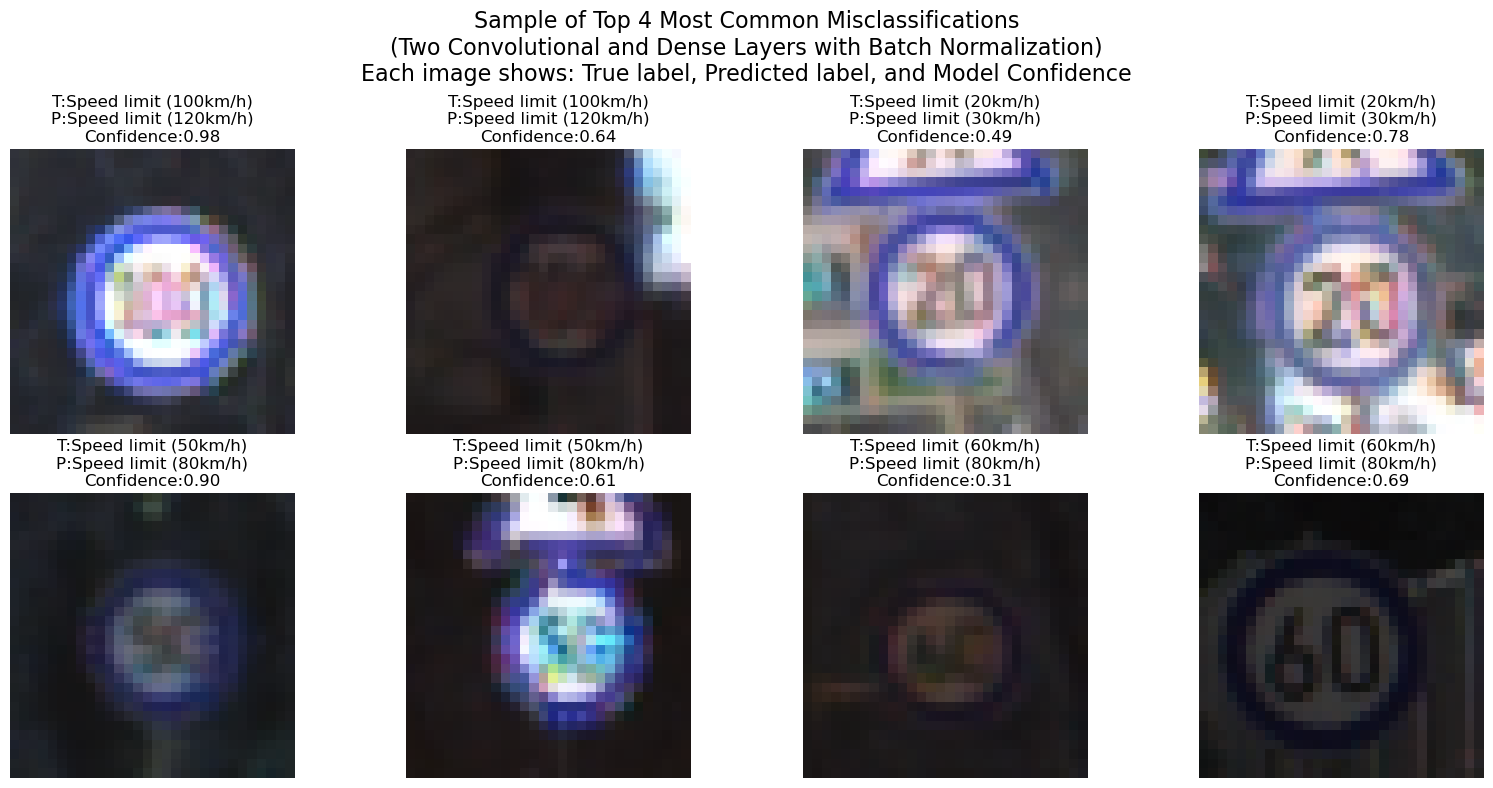

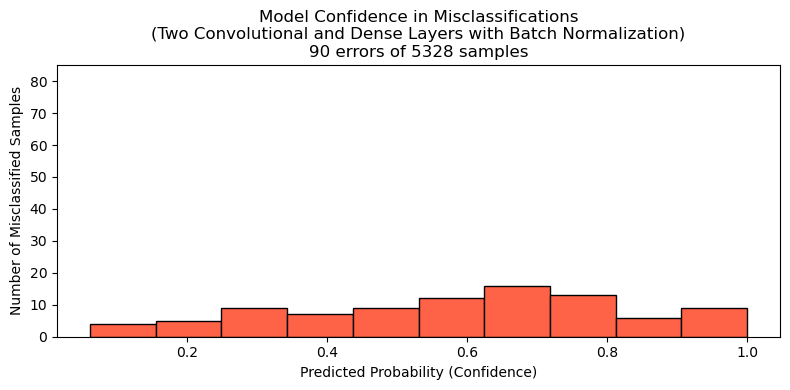

In [23]:
# Evaluate two convolutional + dense layer with batch normalization
train_and_evaluate(Two_Convolutional_and_Dense_Layers_with_Batch_Normalization)

### Results for Two Convolutional + Dense Layers, and Batch Normalization

Adding a second Dense layer to the two-convolutional-layer + batch normalization architecture reduces overall performance compared to the near-perfect two-convolutional + batch normalization model. Accuracy drops to 98.3%, with weighted precision, recall, and f1-score also at ~0.983—strong, but notably below the 99.4% peak achieved without the extra dense layer.

At the class level, performance remains excellent for most categories, with many classes achieving perfect or near-perfect precision and recall. Longstanding problem areas such as class 5 (speed limit signs) hold steady at high performance (precision 0.95, recall 0.98), and minority classes like 6, 21, 29, 33, and 39 remain perfectly classified. However, cracks appear in consistency. Class 0 lags badly (precision 0.94, recall 0.53), while several mid-frequency classes—such as 7 (recall 0.88), 8 (precision 0.90), and 30/41 (f1-scores ~0.96)—underperform relative to earlier convolution-only architectures.

The confidence histogram remains sharply peaked, suggesting confident predictions, but the added dense layer appears to have complicated the decision boundary unnecessarily. The result is a model that is highly accurate overall yet introduces instability in certain classes, undermining the clean improvements achieved by the simpler convolutional + batch normalization design.

In short, while batch normalization continues to stabilize training, the addition of a second dense layer adds little benefit and slightly degrades performance. The evidence suggests that the optimal architecture for this dataset is the two-convolutional-layer backbone with batch normalization, without additional dense complexity.

In [24]:
# Display banner image
display(HTML('''
<div style="max-width:900px;margin:auto;">
  <img src="../static/images/GTSRB_banner.png" class="img-soft-border" alt="Traffic Signs Banner" style="width:100%;">
</div>
'''))

<a id="comparative-model-analysis"></a>

# Comparative Model Analysis

[Back to Top](#)

Model progression shows how each architectural tweak affects performance. The best model balances depth and stability—more convolution and normalization help, while extra dense layers only hinder.

<link rel="stylesheet" href="../static/css/styles.css">

### Model Comparison Table  

| Model                | Accuracy | Precision | Recall | F1-score | Errors | Notes |
|-----------------------|----------|-----------|--------|----------|--------|-------|
| **Baseline Model**        | 96.6%    | 0.967      | 0.966   | 0.966     | 183 | Solid foundation; struggles with minority classes. |
| **+ Class Weights**   | 95.8%    | 0.960      | 0.958   | 0.958     | 222 | Improves minority class metrics; reduces majority performance. Tradeoff observed. |
| **+ Conv Layer**      | 98.3%    | 0.983 | 0.983 | 0.983 | 92 | Enhanced feature extraction; reduces confusion among similar signs. |
| **+ Batch Norm**      | 98.3%    | 0.983 | 0.983 | 0.982 | 93 | Stabilizes training and accelerates convergence; yields more consistent results. |
| **+ Conv + BN**       | **99.4%**| **0.994**  | **0.994** | **0.994** | **31** | **Strongest overall**—high accuracy, few errors across classes. |
| **+ Conv + Dense** | 93.8% | 0.937 | 0.938 | 0.933 | 329 | Added complexity degrades performance; some classes collapse. |
| **+ Conv + Dense + BN**      | 98.3% | 0.983 | 0.983 | 0.983 | 90 | No improvement over Conv+BN; simpler architecture prevails. |
<p class="caption" style="display:flex;justify-content:center;align-items:center;text-align:center;">
  <em>
    <strong>Accuracy</strong>: Proportion of all predictions that are correct.<br>
    <strong>Precision</strong>: Proportion of positive predictions that are correct (True Positives / [True Positives + False Positives]).<br>
    <strong>Recall</strong>: Proportion of actual positives correctly identified (True Positives / [True Positives + False Negatives]).<br>
    <strong>F1-score</strong>: Harmonic mean balancing precision and recall equally.<br>
    <strong>Errors</strong>: Number of misclassifications of 5,328 total samples in validation set.
  </em>
</p>

#### Baseline Model

A simple MNIST-style CNN achieved 96.6% accuracy with strong class-level balance, but struggled with visually similar signs (e.g., speed limits) and some minority categories. Solid foundation but systematic challenges remain.

#### +Class Weights

Minority classes (e.g., 19, 29) improved in recall and precision, but majority classes lost ground, dropping overall accuracy to 95.8%. Highlights the inherent tradeoff in rebalancing imbalanced datasets.

#### +Convolutional Layer

Adding a second conv layer boosted accuracy to 98.3% by extracting richer features, reducing confusion among similar signs, and stabilizing minority performance. Clear gain without overfitting.

#### +Batch Normalization

Batch normalization maintained 98.3% accuracy but smoothed training and improved calibration, especially for minority classes. Reduced variance across runs, yielding more reliable results.

#### +Convolutional Layer + Batch Normalization

The optimal model: **99.4% accuracy**, balanced across nearly all classes, with previously weak categories (e.g., class 5) substantially improved. Depth plus normalization proved the strongest combination.

#### +Dense Layer

Adding an extra dense layer destabilized training, collapsing several classes and cutting accuracy to 93.8%. Demonstrates the risk of unnecessary complexity.


#### +Dense Layer + Batch Normalization

Batch normalization partially mitigated dense-layer instability, recovering to 98.3%. Still fell short of Conv+BN, confirming that added dense layers do not improve generalization.

#### Overall Trajectory

Accuracy improved from **96.6% (Baseline)** to **99.4% (+Conv+BN)**. Class weighting improved minorities but weakened majority performance; convolutional depth enhanced feature extraction; batch normalization stabilized training and calibration. Extra dense layers consistently underperformed. The **two-convolutional-layer + BN model** struck the best balance of accuracy, stability, and class-level consistency.

### And the winner is...  
## Two Convolutional Layers with Batch Normalization

This model achieved **99.4% validation accuracy** with balanced precision/recall and minimal error.


In [25]:
# Display banner image
display(HTML('''
<div style="max-width:900px;margin:auto;">
  <img src="../static/images/GTSRB_banner.png" class="img-soft-border" alt="Traffic Signs Banner" style="width:100%;">
</div>
'''))

<a id="test-set-evaluation"></a>

# Test Set Evaluation

[Back to Top](#)

With training done, the real test is unseen data. The top model—two convolutional layers plus batch normalization—was evaluated on the GTSRB test set. Results confirm strong generalization, balanced class performance, and robust handling of real-world conditions.

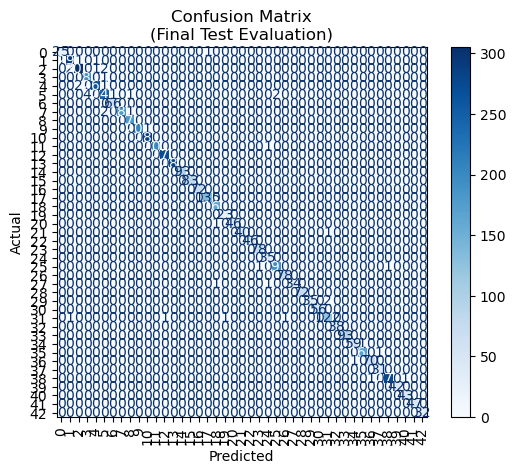

,precision,recall,f1-score,support
accuracy,0.991929,0.991929,0.991929,0.991929
macro avg,0.990396,0.991160,0.990690,5328.000000
weighted avg,0.991979,0.991929,0.991921,5328.000000
0,0.961538,0.961538,0.961538,26.000000
1,0.989761,0.989761,0.989761,293.000000
2,0.990260,0.983871,0.987055,310.000000
3,0.979275,0.994737,0.986945,190.000000
4,0.992453,0.988722,0.990584,266.000000
5,0.976285,0.968627,0.972441,255.000000
6,0.985075,1.000000,0.992481,66.000000


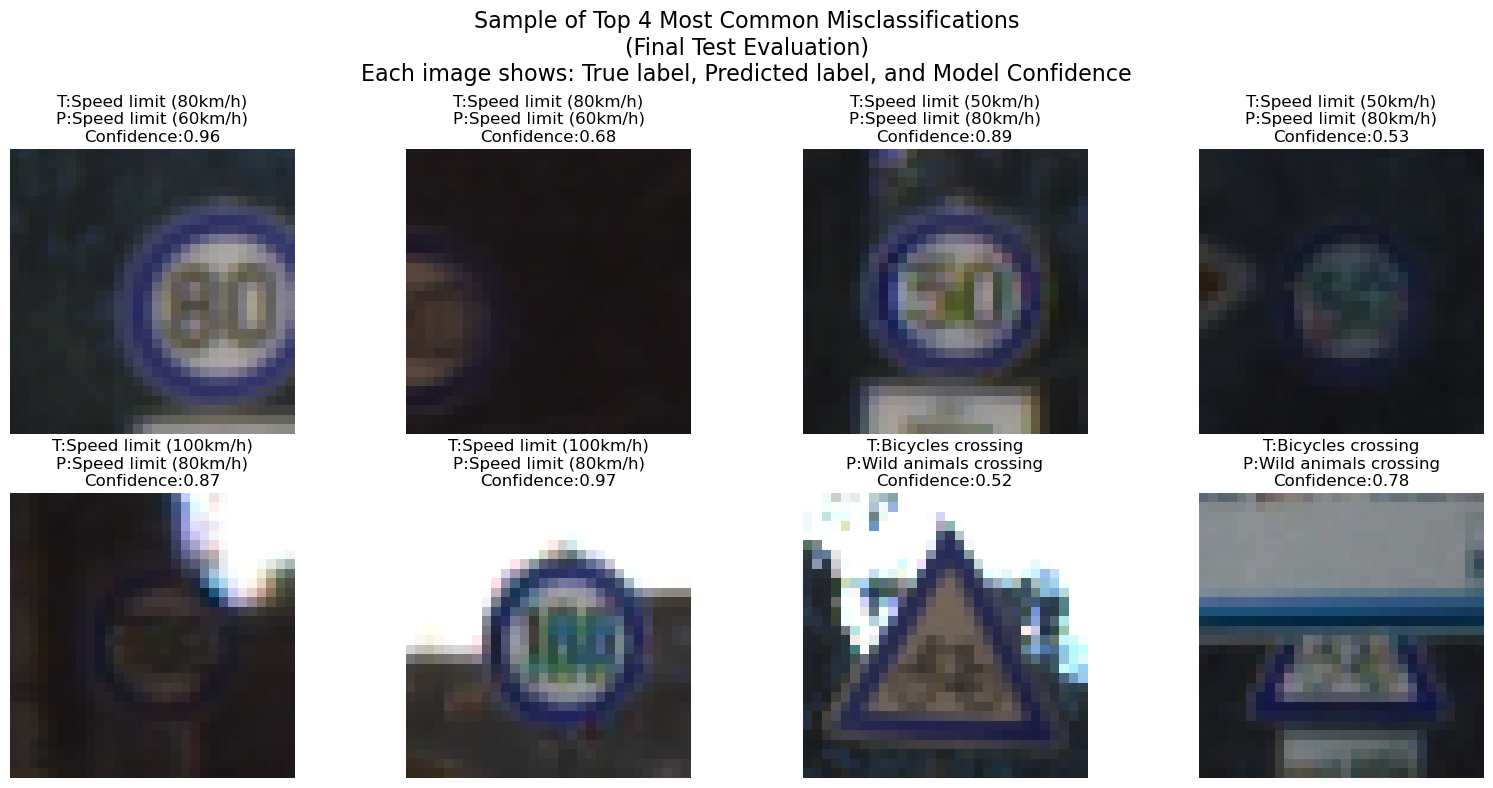

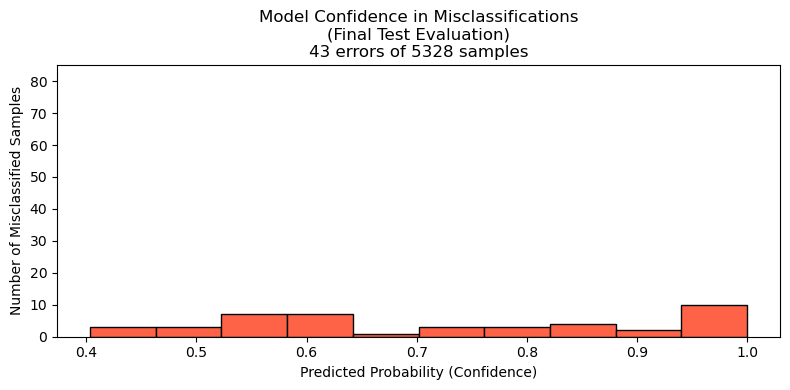

In [26]:
# Evaluate best model on test set
model = load_model("../models/Two_Convolutional_with_Batch_Normalization.h5")

# Evaluate on test set
y_pred = model.predict(x_test, verbose=0)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

plot_and_save_confusion_matrix(y_true, y_pred_classes, "Final_Test_Evaluation")
save_classification_report(y_true, y_pred_classes, "Final_Test_Evaluation")
show_top_misclassifications(
    x_test, y_true, y_pred_classes, y_pred, model_name="Final_Test_Evaluation"
)
most_common_misclassifications(y_true, y_pred_classes, top_n=5)
plot_misclassification_confidence_histogram(
    y_true, y_pred_classes, y_pred, model_name="Final_Test_Evaluation"
)
save_model_summary(model, "Final_Test_Evaluation")

<a id="interpretation-of-test-results"></a>

# Interpretation of Test Results

[Back to Top](#)

On the GTSRB test set, the best model reached **99.2% accuracy**, with weighted precision/recall/F1 all at **0.99**. Performance was consistent across nearly all classes, with only a few small categories (e.g., 24, 27, 29) dipping slightly (~0.97 F1). Most classes achieved or exceeded 0.99, many at perfection. Misclassifications were rare and mostly involved visually similar speed limit signs.

The final model generalized well, confirming that **targeted refinements—extra convolution and batch normalization—drove gains**, while unnecessary dense layers hurt stability. Results demonstrate that **parsimony outperforms complexity** when handling imbalanced, visually similar classes.

## In Conclusion

From baseline to final, the experiments show that **controlled complexity**—not sheer size—produces the most effective models. Strategic use of class weighting and normalization closed gaps in minority and confusing classes, yielding a reliable model with near state-of-the-art accuracy.

Future directions could explore higher-resolution inputs, transfer learning, or cross-domain adaptation to further strengthen performance in applied settings.

In [27]:
# Display banner image
display(HTML('''
<div style="max-width:900px;margin:auto;">
  <img src="../static/images/GTSRB_banner.png" class="img-soft-border" alt="Traffic Signs Banner" style="width:100%;">
</div>
'''))

<!-- <div class="circle-separator-anchor"></div> -->

<!-- Footer -->
<footer class="site-footer" role="contentinfo">
  <span class="footer-owner">
    &copy; <span id="copyright-year">2025</span>
    <span class="footer-author">Bryan C. Johns</span>
  </span>
  <span class="footer-links">
    <a href="https://johbry17.github.io/portfolio/index.html" target="_blank" class="portfolio-link" aria-label="Portfolio">
      <i class="fas fa-laptop-code footer-icon" aria-hidden="true" title="Portfolio"></i>Portfolio
    </a>
    <a href="https://www.linkedin.com/in/b-johns/" target="_blank" class="linkedin-link" aria-label="LinkedIn">
      <i class="fab fa-linkedin footer-icon" aria-hidden="true" title="LinkedIn"></i>LinkedIn
    </a>
    <a href="https://github.com/johbry17/Red-Light-Green-Light" target="_blank" class="github-link" aria-label="GitHub">
      <i class="fab fa-github footer-icon" aria-hidden="true" title="GitHub"></i>GitHub
    </a>
  </span>
</footer>
<script>
  // Auto-update year
  const yearElement = document.getElementById("copyright-year");
  if (yearElement) {
    yearElement.textContent = new Date().getFullYear();
  }
</script>

<script src="https://cdn.jsdelivr.net/npm/bootstrap@5.3.3/dist/js/bootstrap.bundle.min.js"></script>
<script src="../static/js/scripts.js"></script>
<script>
  document.addEventListener('DOMContentLoaded', function() {
    insertCircleSeparator('.circle-separator-anchor');
  });
</script>

